In [12]:
# Data Loading & Initial Inspection
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Set display options for better visualization
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

# Load the dataset
file_path = r"D:\Market Projects\options_data_analyzer\Aug '25\Aug 07 Exp\07 Aug\24400CE.csv"

# Read CSV with proper datetime parsing
df = pd.read_csv(file_path, parse_dates=['date'])

print("=== DATASET LOADED SUCCESSFULLY ===")
print(f"File: 24400CE.csv")
print(f"Path: {file_path}")
print()

# 1. Check data shape
print("=== DATA SHAPE ===")
print(f"Rows: {df.shape[0]:,}")
print(f"Columns: {df.shape[1]}")
print()

# 2. Check data types
print("=== DATA TYPES ===")
print(df.dtypes)
print()

# 3. Check for null/missing values
print("=== NULL VALUES CHECK ===")
null_counts = df.isnull().sum()
if null_counts.sum() == 0:
    print("✅ No null values found in the dataset")
else:
    print("❌ Null values found:")
    print(null_counts[null_counts > 0])
print()

# 4. Preview first few rows
print("=== FIRST 10 ROWS ===")
print(df.head(10))
print()

# 5. Preview last few rows
print("=== LAST 5 ROWS ===")
print(df.tail())
print()

# 6. Basic statistics
print("=== BASIC STATISTICS ===")
print(df.describe())
print()

# 7. Column information
print("=== COLUMN INFORMATION ===")
print("Columns in the dataset:")
for i, col in enumerate(df.columns, 1):
    print(f"{i}. {col}")
print()

# 8. Date range information
print("=== DATE RANGE ===")
print(f"Start Date: {df['date'].min()}")
print(f"End Date: {df['date'].max()}")
print(f"Total Time Span: {df['date'].max() - df['date'].min()}")
print()

# 9. Memory usage
print("=== MEMORY USAGE ===")
memory_usage = df.memory_usage(deep=True)
print(f"Total Memory Usage: {memory_usage.sum() / 1024 / 1024:.2f} MB")
print("Memory usage per column:")
for col in df.columns:
    print(f"  {col}: {memory_usage[col] / 1024:.2f} KB")

print("\n" + "="*50)
print("✅ DATASET READY FOR ANALYSIS")
print("="*50)

=== DATASET LOADED SUCCESSFULLY ===
File: 24400CE.csv
Path: D:\Market Projects\options_data_analyzer\Aug '25\Aug 07 Exp\07 Aug\24400CE.csv

=== DATA SHAPE ===
Rows: 26,747
Columns: 5

=== DATA TYPES ===
date         datetime64[ns]
price               float64
qty                   int64
trnvr               float64
cum_trnvr           float64
dtype: object

=== NULL VALUES CHECK ===
✅ No null values found in the dataset

=== FIRST 10 ROWS ===
                 date   price    qty       trnvr    cum_trnvr
0 2025-07-08 09:15:00  132.40   1125   148950.00    148950.00
1 2025-07-08 09:15:00  132.65   1425   189026.25    337976.25
2 2025-07-08 09:15:00  132.70   9525  1263967.50   1601943.75
3 2025-07-08 09:15:00  131.45   1125   147881.25   1749825.00
4 2025-07-08 09:15:00  138.55  40125  5559318.75   7309143.75
5 2025-07-08 09:15:00  139.00   3300   458700.00   7767843.75
6 2025-07-08 09:15:00  147.35  40575  5978726.25  13746570.00
7 2025-07-08 09:15:00  147.80   4500   665100.00  14411670.

In [13]:
# Data Cleaning & Preprocessing
print("=== DATA CLEANING & PREPROCESSING ===")
print()

# 1. Verify datetime format and convert if needed
print("1. DATETIME PROCESSING")
print(f"Original date column dtype: {df['date'].dtype}")
if df['date'].dtype == 'object':
    df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d %I:%M:%S %p')
    print("✅ Converted date column to datetime")
else:
    print("✅ Date column already in datetime format")
print(f"Final date column dtype: {df['date'].dtype}")
print()

# 2. Check for missing values and handle them
print("2. MISSING VALUES HANDLING")
missing_before = df.isnull().sum()
print("Missing values before cleaning:")
print(missing_before)
print()

# Handle missing values based on domain logic
if missing_before.sum() > 0:
    # For price: forward fill (use last known price)
    if df['price'].isnull().sum() > 0:
        df['price'] = df['price'].fillna(method='ffill')
        print("✅ Forward filled missing prices")
    
    # For qty: fill with 0 (no trade)
    if df['qty'].isnull().sum() > 0:
        df['qty'] = df['qty'].fillna(0)
        print("✅ Filled missing quantities with 0")
    
    # For trnvr: calculate from price * qty if missing
    if df['trnvr'].isnull().sum() > 0:
        df['trnvr'] = df['trnvr'].fillna(df['price'] * df['qty'])
        print("✅ Calculated missing turnover values")
    
    # For cum_trnvr: recalculate cumulative sum
    if df['cum_trnvr'].isnull().sum() > 0:
        df['cum_trnvr'] = df['trnvr'].cumsum()
        print("✅ Recalculated cumulative turnover")

missing_after = df.isnull().sum()
print("Missing values after cleaning:")
print(missing_after)
print()

# 3. Handle zero quantities and prices
print("3. ZERO VALUES ANALYSIS")
zero_qty_count = (df['qty'] == 0).sum()
zero_price_count = (df['price'] == 0).sum()
print(f"Rows with zero quantity: {zero_qty_count:,} ({zero_qty_count/len(df)*100:.2f}%)")
print(f"Rows with zero price: {zero_price_count:,} ({zero_price_count/len(df)*100:.2f}%)")

# For options data, zero quantity might indicate no trades (bid/ask spread)
# Zero price might indicate invalid data
if zero_price_count > 0:
    print("⚠️  Warning: Found rows with zero price - these might be invalid")
    # Option: Remove rows with zero price
    # df = df[df['price'] > 0]
    # print(f"Removed {zero_price_count} rows with zero price")

print()

# 4. Sort data by datetime to maintain chronological order
print("4. SORTING DATA")
print(f"Data sorted before: {df['date'].iloc[0]} to {df['date'].iloc[-1]}")
df = df.sort_values('date').reset_index(drop=True)
print(f"Data sorted after: {df['date'].iloc[0]} to {df['date'].iloc[-1]}")
print("✅ Data sorted chronologically")
print()

# 5. Add derived columns
print("5. ADDING DERIVED COLUMNS")

# Time-based columns
df['hour'] = df['date'].dt.hour
df['minute'] = df['date'].dt.minute
df['time_of_day'] = df['date'].dt.time
df['date_only'] = df['date'].dt.date

# Price change and returns
df['price_change'] = df['price'].diff()
df['price_change_pct'] = df['price'].pct_change() * 100

# Log returns (for financial analysis)
df['log_return'] = np.log(df['price'] / df['price'].shift(1))

# Volume and turnover analysis
df['volume_ma_5'] = df['qty'].rolling(window=5, min_periods=1).mean()
df['price_ma_5'] = df['price'].rolling(window=5, min_periods=1).mean()

# Volatility (rolling standard deviation of returns)
df['volatility_5'] = df['price_change_pct'].rolling(window=5, min_periods=1).std()

# Trade intensity (quantity per minute)
df['trade_intensity'] = df['qty'] / df['qty'].rolling(window=10, min_periods=1).mean()

print("✅ Added derived columns:")
print("   - Time components (hour, minute, time_of_day, date_only)")
print("   - Price analysis (price_change, price_change_pct, log_return)")
print("   - Moving averages (volume_ma_5, price_ma_5)")
print("   - Volatility (volatility_5)")
print("   - Trade intensity")
print()

# 6. Data quality checks
print("6. DATA QUALITY CHECKS")

# Check for negative prices
negative_prices = (df['price'] < 0).sum()
if negative_prices > 0:
    print(f"⚠️  Warning: {negative_prices} rows with negative prices")
else:
    print("✅ No negative prices found")

# Check for negative quantities
negative_qty = (df['qty'] < 0).sum()
if negative_qty > 0:
    print(f"⚠️  Warning: {negative_qty} rows with negative quantities")
else:
    print("✅ No negative quantities found")

# Check for negative turnover
negative_trnvr = (df['trnvr'] < 0).sum()
if negative_trnvr > 0:
    print(f"⚠️  Warning: {negative_trnvr} rows with negative turnover")
else:
    print("✅ No negative turnover found")

# Check for price outliers (beyond 3 standard deviations)
price_mean = df['price'].mean()
price_std = df['price'].std()
outliers = ((df['price'] > price_mean + 3*price_std) | (df['price'] < price_mean - 3*price_std)).sum()
print(f"Price outliers (beyond 3σ): {outliers:,} ({outliers/len(df)*100:.2f}%)")

print()

# 7. Final dataset summary
print("7. FINAL DATASET SUMMARY")
print(f"Final shape: {df.shape[0]:,} rows × {df.shape[1]} columns")
print(f"Date range: {df['date'].min()} to {df['date'].max()}")
print(f"Total trading volume: {df['qty'].sum():,.0f}")
print(f"Total turnover: ₹{df['trnvr'].sum():,.2f}")
print(f"Average price: ₹{df['price'].mean():.2f}")
print(f"Price range: ₹{df['price'].min():.2f} - ₹{df['price'].max():.2f}")

print("\n" + "="*50)
print("✅ DATA CLEANING & PREPROCESSING COMPLETED")
print("="*50)

=== DATA CLEANING & PREPROCESSING ===

1. DATETIME PROCESSING
Original date column dtype: datetime64[ns]
✅ Date column already in datetime format
Final date column dtype: datetime64[ns]

2. MISSING VALUES HANDLING
Missing values before cleaning:
date         0
price        0
qty          0
trnvr        0
cum_trnvr    0
dtype: int64

Missing values after cleaning:
date         0
price        0
qty          0
trnvr        0
cum_trnvr    0
dtype: int64

3. ZERO VALUES ANALYSIS
Rows with zero quantity: 0 (0.00%)
Rows with zero price: 0 (0.00%)

4. SORTING DATA
Data sorted before: 2025-07-08 09:15:00 to 2025-07-08 15:29:00
Data sorted after: 2025-07-08 09:15:00 to 2025-07-08 15:29:00
✅ Data sorted chronologically

5. ADDING DERIVED COLUMNS
✅ Added derived columns:
   - Time components (hour, minute, time_of_day, date_only)
   - Price analysis (price_change, price_change_pct, log_return)
   - Moving averages (volume_ma_5, price_ma_5)
   - Volatility (volatility_5)
   - Trade intensity

6. DA

In [14]:
# Basic Descriptive Analytics
print("=== BASIC DESCRIPTIVE ANALYTICS ===")
print()

# 1. Basic Statistics for Key Variables
print("1. BASIC STATISTICS")
print("=" * 60)

# Create a comprehensive statistics table
stats_data = {
    'Price (₹)': {
        'Count': len(df['price']),
        'Mean': df['price'].mean(),
        'Median': df['price'].median(),
        'Std Dev': df['price'].std(),
        'Min': df['price'].min(),
        'Max': df['price'].max(),
        'Variance': df['price'].var(),
        'Skewness': df['price'].skew(),
        'Kurtosis': df['price'].kurtosis()
    },
    'Quantity': {
        'Count': len(df['qty']),
        'Mean': df['qty'].mean(),
        'Median': df['qty'].median(),
        'Std Dev': df['qty'].std(),
        'Min': df['qty'].min(),
        'Max': df['qty'].max(),
        'Variance': df['qty'].var(),
        'Skewness': df['qty'].skew(),
        'Kurtosis': df['qty'].kurtosis()
    },
    'Turnover (₹)': {
        'Count': len(df['trnvr']),
        'Mean': df['trnvr'].mean(),
        'Median': df['trnvr'].median(),
        'Std Dev': df['trnvr'].std(),
        'Min': df['trnvr'].min(),
        'Max': df['trnvr'].max(),
        'Variance': df['trnvr'].var(),
        'Skewness': df['trnvr'].skew(),
        'Kurtosis': df['trnvr'].kurtosis()
    }
}

# Display statistics in a formatted table
stats_df = pd.DataFrame(stats_data).round(2)
print(stats_df)
print()

# 2. Volume Analysis
print("2. VOLUME ANALYSIS")
print("=" * 60)

# Calculate volume metrics
total_volume = df['qty'].sum()
total_trades = len(df[df['qty'] > 0])  # Only rows with actual trades
avg_qty_per_trade = df[df['qty'] > 0]['qty'].mean() if total_trades > 0 else 0
max_single_trade = df['qty'].max()
min_single_trade = df[df['qty'] > 0]['qty'].min() if total_trades > 0 else 0

print(f"📊 Total Volume Traded: {total_volume:,.0f} contracts")
print(f"📈 Total Number of Trades: {total_trades:,}")
print(f"📊 Average Quantity per Trade: {avg_qty_per_trade:,.0f} contracts")
print(f"📈 Maximum Single Trade: {max_single_trade:,.0f} contracts")
print(f"📊 Minimum Single Trade: {min_single_trade:,.0f} contracts")
print(f"�� Volume per Minute: {total_volume / (len(df['date'].dt.time.unique()) or 1):,.0f} contracts")

# Volume distribution analysis
print("\n📊 Volume Distribution:")
volume_quartiles = df[df['qty'] > 0]['qty'].quantile([0.25, 0.5, 0.75, 0.9, 0.95, 0.99])
for percentile, value in volume_quartiles.items():
    print(f"   {percentile*100:.0f}th percentile: {value:,.0f} contracts")

print()

# 3. Price Range and Volatility Analysis
print("3. PRICE RANGE & VOLATILITY ANALYSIS")
print("=" * 60)

# Price range metrics
price_range = df['price'].max() - df['price'].min()
price_range_pct = (price_range / df['price'].min()) * 100

print(f"💰 Price Range: ₹{price_range:.2f} ({price_range_pct:.2f}% of min price)")
print(f"💰 Highest Price: ₹{df['price'].max():.2f}")
print(f"�� Lowest Price: ₹{df['price'].min():.2f}")
print(f"💰 Average Price: ₹{df['price'].mean():.2f}")
print(f"�� Median Price: ₹{df['price'].median():.2f}")

# Volatility measures
print("\n📈 Volatility Measures:")
print(f"   Standard Deviation: ₹{df['price'].std():.2f}")
print(f"   Coefficient of Variation: {(df['price'].std() / df['price'].mean()) * 100:.2f}%")
print(f"   Average Price Change: ₹{df['price_change'].abs().mean():.2f}")
print(f"   Average Price Change %: {df['price_change_pct'].abs().mean():.2f}%")
print(f"   Max Price Change: ₹{df['price_change'].abs().max():.2f}")
print(f"   Max Price Change %: {df['price_change_pct'].abs().max():.2f}%")

# Rolling volatility
if 'volatility_5' in df.columns:
    print(f"   Average 5-period Volatility: {df['volatility_5'].mean():.2f}%")
    print(f"   Max 5-period Volatility: {df['volatility_5'].max():.2f}%")

print()

# 4. Turnover Analysis
print("4. TURNOVER ANALYSIS")
print("=" * 60)

total_turnover = df['trnvr'].sum()
avg_turnover_per_trade = df[df['trnvr'] > 0]['trnvr'].mean() if len(df[df['trnvr'] > 0]) > 0 else 0
max_turnover = df['trnvr'].max()

print(f"�� Total Turnover: ₹{total_turnover:,.2f}")
print(f"💵 Average Turnover per Trade: ₹{avg_turnover_per_trade:,.2f}")
print(f"💵 Maximum Single Trade Turnover: ₹{max_turnover:,.2f}")
print(f"💵 Turnover per Minute: ₹{total_turnover / (len(df['date'].dt.time.unique()) or 1):,.2f}")

# Turnover distribution
print("\n💵 Turnover Distribution:")
turnover_quartiles = df[df['trnvr'] > 0]['trnvr'].quantile([0.25, 0.5, 0.75, 0.9, 0.95, 0.99])
for percentile, value in turnover_quartiles.items():
    print(f"   {percentile*100:.0f}th percentile: ₹{value:,.2f}")

print()

# 5. Trading Session Summary
print("5. TRADING SESSION SUMMARY")
print("=" * 60)

session_start = df['date'].min()
session_end = df['date'].max()
session_duration = session_end - session_start

print(f"🕐 Session Start: {session_start}")
print(f"🕐 Session End: {session_end}")
print(f"🕐 Session Duration: {session_duration}")

# Trading intensity
active_minutes = len(df['date'].dt.time.unique())
total_minutes = (session_end - session_start).total_seconds() / 60

print(f"📊 Active Trading Minutes: {active_minutes}")
print(f"�� Average Volume per Active Minute: {total_volume / active_minutes:,.0f} contracts")
print(f"📊 Average Turnover per Active Minute: ₹{total_turnover / active_minutes:,.2f}")

# Price efficiency (how much price moved vs volume)
price_efficiency = abs(df['price'].iloc[-1] - df['price'].iloc[0]) / total_volume * 1000000
print(f"�� Price Efficiency (price change per million contracts): {price_efficiency:.4f}")

print()

# 6. Key Performance Indicators
print("6. KEY PERFORMANCE INDICATORS")
print("=" * 60)

# Calculate KPIs
avg_trade_size = total_volume / total_trades if total_trades > 0 else 0
price_volatility = df['price'].std() / df['price'].mean() * 100
volume_concentration = (df['qty'].nlargest(10).sum() / total_volume) * 100

print(f"�� Average Trade Size: {avg_trade_size:,.0f} contracts")
print(f"📈 Price Volatility: {price_volatility:.2f}%")
print(f"📊 Volume Concentration (Top 10 trades): {volume_concentration:.2f}%")
print(f"📈 Price Change for Session: ₹{df['price'].iloc[-1] - df['price'].iloc[0]:.2f}")
print(f"�� Price Change % for Session: {((df['price'].iloc[-1] / df['price'].iloc[0]) - 1) * 100:.2f}%")

print("\n" + "="*60)
print("✅ BASIC DESCRIPTIVE ANALYTICS COMPLETED")
print("="*60)

=== BASIC DESCRIPTIVE ANALYTICS ===

1. BASIC STATISTICS
          Price (₹)      Quantity  Turnover (₹)
Count      26747.00  2.674700e+04  2.674700e+04
Mean          75.15  4.282858e+04  1.967179e+06
Median        53.45  1.717500e+04  1.012489e+06
Std Dev       48.08  7.888327e+04  3.182449e+06
Min           10.70  7.500000e+01  1.143750e+03
Max          196.50  1.528575e+06  7.947096e+07
Variance    2312.13  6.222571e+09  1.012798e+13
Skewness       0.93  5.620000e+00  5.960000e+00
Kurtosis      -0.05  5.146000e+01  6.663000e+01

2. VOLUME ANALYSIS
📊 Total Volume Traded: 1,145,536,050 contracts
📈 Total Number of Trades: 26,747
📊 Average Quantity per Trade: 42,829 contracts
📈 Maximum Single Trade: 1,528,575 contracts
📊 Minimum Single Trade: 75 contracts
�� Volume per Minute: 3,054,763 contracts

📊 Volume Distribution:
   25th percentile: 4,725 contracts
   50th percentile: 17,175 contracts
   75th percentile: 46,875 contracts
   90th percentile: 108,525 contracts
   95th percentile: 1

=== TIME-BASED AGGREGATIONS & RESAMPLING ===

1. FILTERING DATA (EXCLUDING ZERO QUANTITY ROWS)
Original dataset: 26,747 rows
After filtering (qty > 0): 26,747 rows
Removed 0 rows with zero quantity

Creating 1min bars...
✅ 1min: 375 bars created
   Time range: 2025-07-08 09:15:00 to 2025-07-08 15:29:00

Creating 5min bars...
✅ 5min: 75 bars created
   Time range: 2025-07-08 09:15:00 to 2025-07-08 15:25:00

Creating 10min bars...
✅ 10min: 38 bars created
   Time range: 2025-07-08 09:10:00 to 2025-07-08 15:20:00

Creating 15min bars...
✅ 15min: 25 bars created
   Time range: 2025-07-08 09:15:00 to 2025-07-08 15:15:00

Creating 30min bars...
✅ 30min: 13 bars created
   Time range: 2025-07-08 09:00:00 to 2025-07-08 15:00:00

2. SAMPLE OF RESAMPLED DATA
📊 1-Minute Bars (First 10 rows):
                     price_open  price_high  price_low  price_close  \
date                                                                  
2025-07-08 09:15:00      132.40      149.20     129.00       138.0

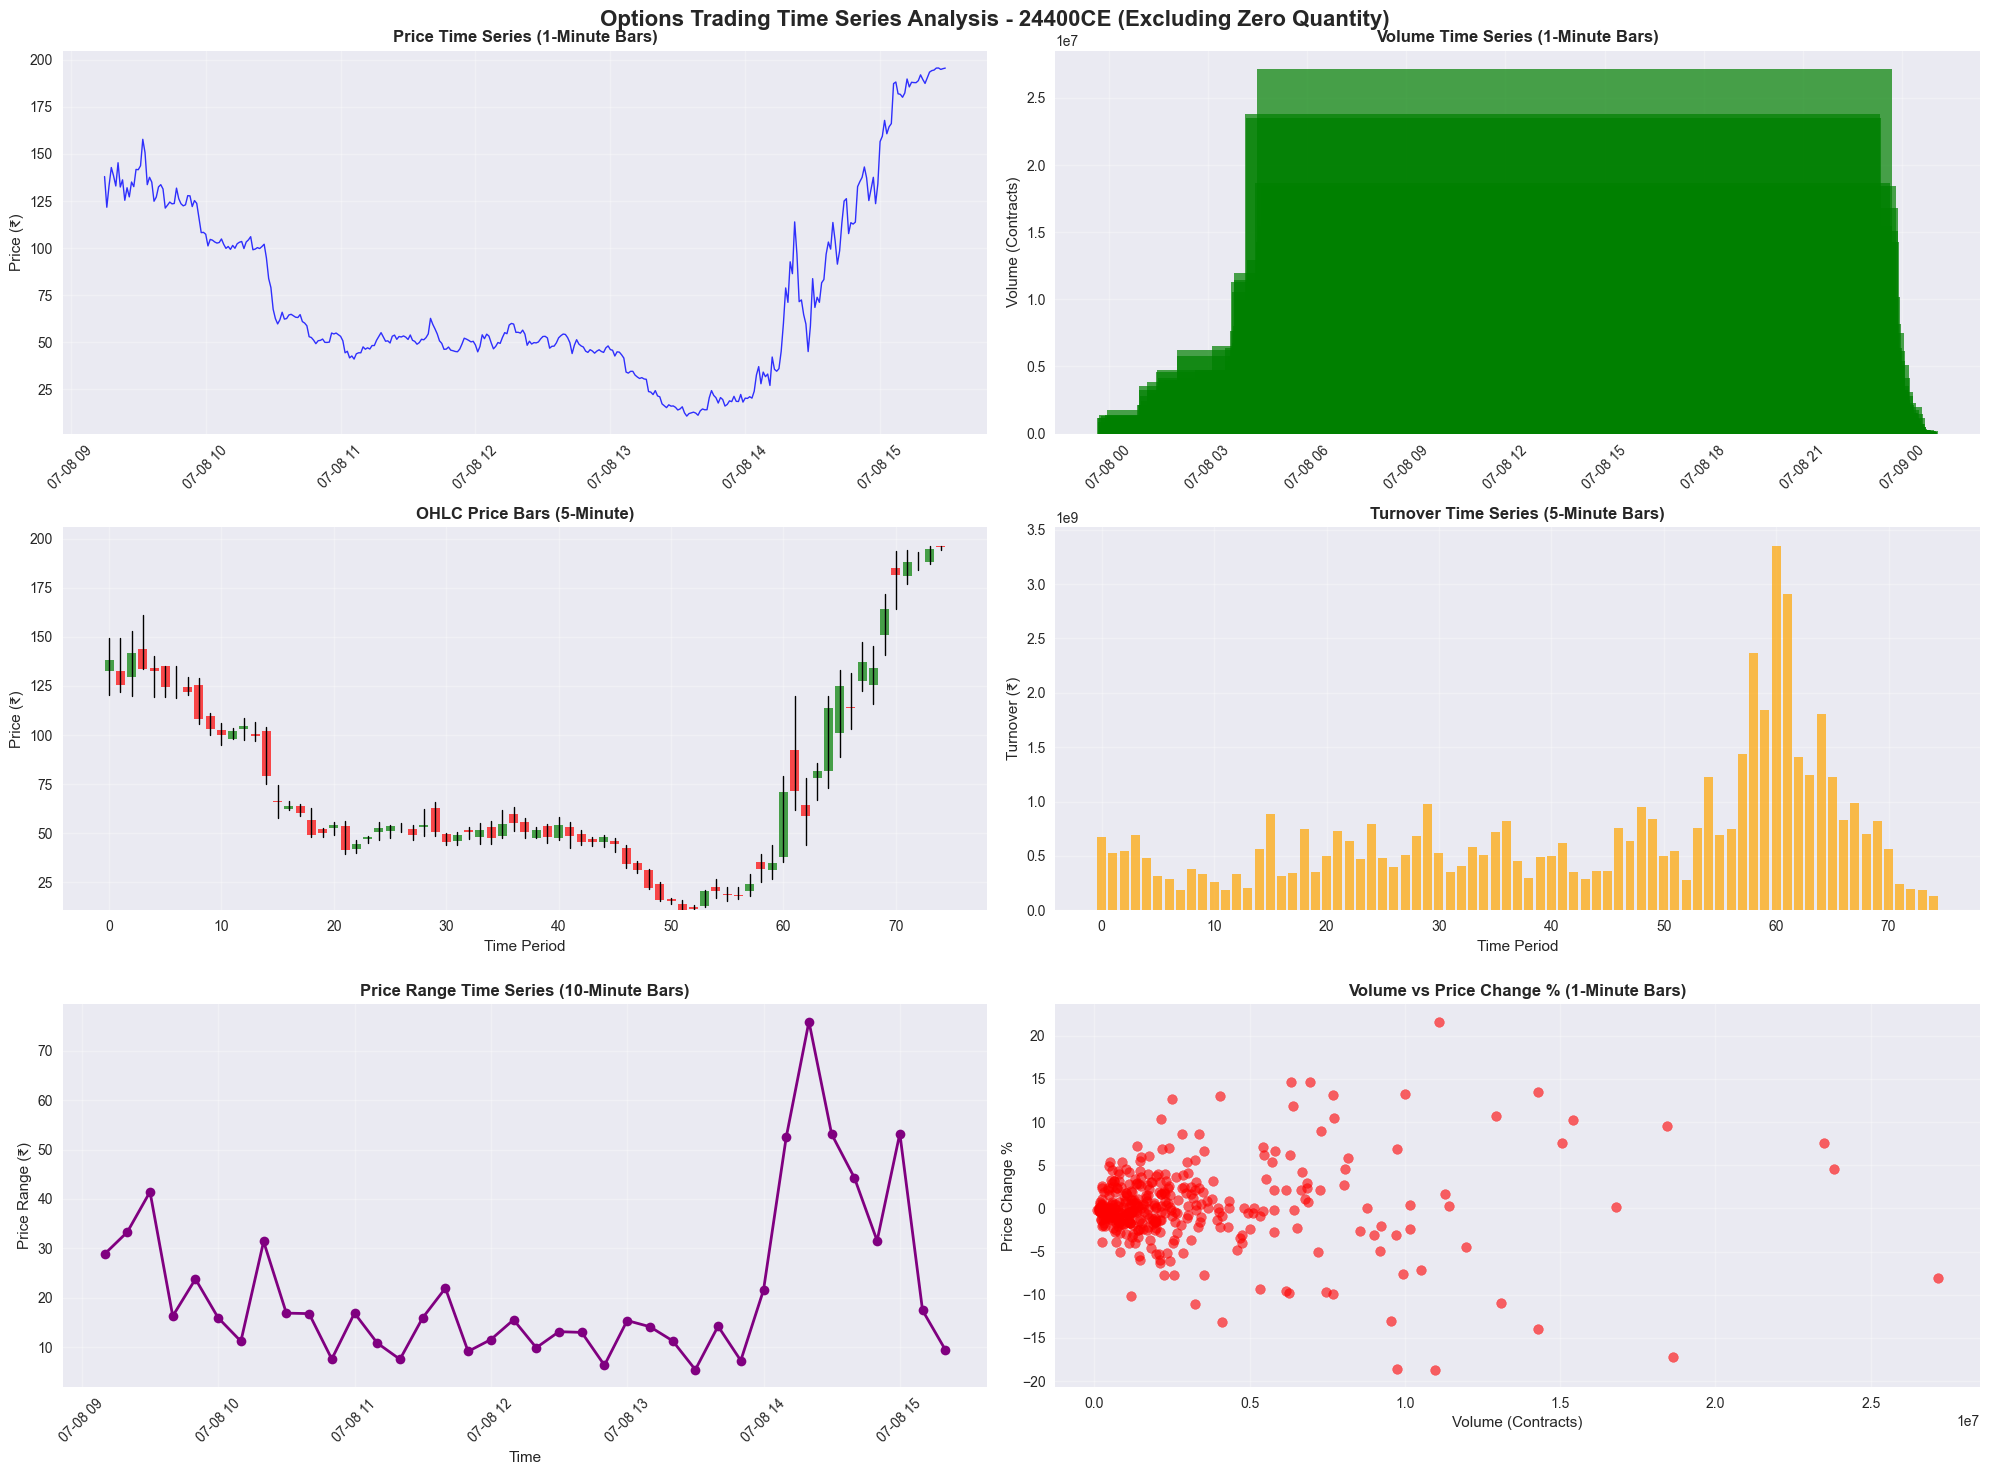

5. ADDITIONAL TIME-BASED ANALYSIS
📊 Hourly Trading Summary (Excluding Zero Quantity):
                       open   close   high     low  mean_price     volume  \
date                                                                        
2025-07-08 09:00:00  132.40  108.35  161.0  105.60  129.729331   30996675   
2025-07-08 10:00:00  109.80   54.00  111.1   48.05   78.799076   74187900   
2025-07-08 11:00:00   53.70   50.45   66.0   39.50   49.780150  139192650   
2025-07-08 12:00:00   48.20   48.00   63.1   42.60   50.413450  117622950   
2025-07-08 13:00:00   46.20   18.15   47.6   10.70   22.906815  404775225   
2025-07-08 14:00:00   20.75  134.10  147.4   17.85   79.819773  366542850   
2025-07-08 15:00:00  151.00  195.65  196.5  140.55  184.821382   12217800   

                         turnover  price_change  price_change_pct  
date                                                               
2025-07-08 09:00:00  4.092091e+09        -24.05        -18.164653  
2025-07-08 10:00

In [15]:
# Time-Based Aggregations & Resampling
print("=== TIME-BASED AGGREGATIONS & RESAMPLING ===")
print()

# 1. Filter out rows with zero quantity
print("1. FILTERING DATA (EXCLUDING ZERO QUANTITY ROWS)")
print("=" * 60)

# Filter out rows where qty = 0
df_filtered = df[df['qty'] > 0].copy()
print(f"Original dataset: {len(df):,} rows")
print(f"After filtering (qty > 0): {len(df_filtered):,} rows")
print(f"Removed {len(df) - len(df_filtered):,} rows with zero quantity")
print()

# Set the filtered date column as index for resampling
df_temp = df_filtered.set_index('date')

# Create different time intervals
intervals = {
    '1min': '1T',
    '5min': '5T', 
    '10min': '10T',
    '15min': '15T',
    '30min': '30T'
}

# Dictionary to store resampled dataframes
resampled_data = {}

for interval_name, interval_code in intervals.items():
    print(f"Creating {interval_name} bars...")
    
    # Resample and aggregate using separate operations
    resampled = df_temp.resample(interval_code).agg({
        'price': ['first', 'max', 'min', 'last', 'mean'],
        'qty': 'sum',
        'trnvr': 'sum',
        'cum_trnvr': 'last'
    })
    
    # Flatten column names
    resampled.columns = [f"{col[0]}_{col[1]}" if col[1] else col[0] for col in resampled.columns]
    
    # Rename price columns to OHLC format
    resampled = resampled.rename(columns={
        'price_first': 'price_open',
        'price_max': 'price_high',
        'price_min': 'price_low',
        'price_last': 'price_close',
        'price_mean': 'price_mean',
        'qty_sum': 'volume',
        'trnvr_sum': 'turnover'
    })
    
    # Add derived columns
    resampled['price_range'] = resampled['price_high'] - resampled['price_low']
    resampled['price_range_pct'] = (resampled['price_range'] / resampled['price_low']) * 100
    resampled['price_change'] = resampled['price_close'] - resampled['price_open']
    resampled['price_change_pct'] = (resampled['price_change'] / resampled['price_open']) * 100
    
    # Remove rows with no data
    resampled = resampled.dropna()
    
    resampled_data[interval_name] = resampled
    
    print(f"✅ {interval_name}: {len(resampled)} bars created")
    print(f"   Time range: {resampled.index.min()} to {resampled.index.max()}")
    print()

# 2. Display sample of resampled data
print("2. SAMPLE OF RESAMPLED DATA")
print("=" * 60)

# Show 1-minute bars as example
print("📊 1-Minute Bars (First 10 rows):")
print(resampled_data['1min'].head(10))
print()

print("📊 5-Minute Bars (First 5 rows):")
print(resampled_data['5min'].head())
print()

# 3. Summary statistics for different intervals
print("3. SUMMARY STATISTICS BY INTERVAL")
print("=" * 60)

summary_stats = {}
for interval_name, data in resampled_data.items():
    stats = {
        'Total Bars': len(data),
        'Avg Volume per Bar': data['volume'].mean(),
        'Max Volume per Bar': data['volume'].max(),
        'Avg Turnover per Bar': data['turnover'].mean(),
        'Max Turnover per Bar': data['turnover'].max(),
        'Avg Price Range': data['price_range'].mean(),
        'Max Price Range': data['price_range'].max(),
        'Avg Price Change %': data['price_change_pct'].abs().mean(),
        'Max Price Change %': data['price_change_pct'].abs().max()
    }
    summary_stats[interval_name] = stats

summary_df = pd.DataFrame(summary_stats).round(2)
print(summary_df)
print()

# 4. Plotting Time Series
print("4. PLOTTING TIME SERIES")
print("=" * 60)

# Set up the plotting style
plt.style.use('seaborn-v0_8')
fig, axes = plt.subplots(3, 2, figsize=(20, 15))
fig.suptitle('Options Trading Time Series Analysis - 24400CE (Excluding Zero Quantity)', fontsize=16, fontweight='bold')

# 1. Price Time Series (1-min bars)
ax1 = axes[0, 0]
data_1min = resampled_data['1min']
ax1.plot(data_1min.index, data_1min['price_close'], linewidth=1, color='blue', alpha=0.8)
ax1.set_title('Price Time Series (1-Minute Bars)', fontweight='bold')
ax1.set_ylabel('Price (₹)')
ax1.grid(True, alpha=0.3)
ax1.tick_params(axis='x', rotation=45)

# 2. Volume Time Series (1-min bars)
ax2 = axes[0, 1]
ax2.bar(data_1min.index, data_1min['volume'], alpha=0.7, color='green')
ax2.set_title('Volume Time Series (1-Minute Bars)', fontweight='bold')
ax2.set_ylabel('Volume (Contracts)')
ax2.grid(True, alpha=0.3)
ax2.tick_params(axis='x', rotation=45)

# 3. OHLC Candlestick-like (5-min bars)
ax3 = axes[1, 0]
data_5min = resampled_data['5min']
for i, (idx, row) in enumerate(data_5min.iterrows()):
    # High-Low line
    ax3.plot([i, i], [row['price_low'], row['price_high']], color='black', linewidth=1)
    # Open-Close body
    if row['price_close'] >= row['price_open']:
        color = 'green'
        body_height = row['price_close'] - row['price_open']
        body_bottom = row['price_open']
    else:
        color = 'red'
        body_height = row['price_open'] - row['price_close']
        body_bottom = row['price_close']
    
    ax3.bar(i, body_height, bottom=body_bottom, color=color, alpha=0.7, width=0.8)

ax3.set_title('OHLC Price Bars (5-Minute)', fontweight='bold')
ax3.set_ylabel('Price (₹)')
ax3.set_xlabel('Time Period')
ax3.grid(True, alpha=0.3)

# 4. Turnover Time Series (5-min bars)
ax4 = axes[1, 1]
ax4.bar(range(len(data_5min)), data_5min['turnover'], alpha=0.7, color='orange')
ax4.set_title('Turnover Time Series (5-Minute Bars)', fontweight='bold')
ax4.set_ylabel('Turnover (₹)')
ax4.set_xlabel('Time Period')
ax4.grid(True, alpha=0.3)

# 5. Price Range Analysis (10-min bars)
ax5 = axes[2, 0]
data_10min = resampled_data['10min']
ax5.plot(data_10min.index, data_10min['price_range'], linewidth=2, color='purple', marker='o')
ax5.set_title('Price Range Time Series (10-Minute Bars)', fontweight='bold')
ax5.set_ylabel('Price Range (₹)')
ax5.set_xlabel('Time')
ax5.grid(True, alpha=0.3)
ax5.tick_params(axis='x', rotation=45)

# 6. Volume vs Price Change Scatter
ax6 = axes[2, 1]
ax6.scatter(data_1min['volume'], data_1min['price_change_pct'], alpha=0.6, color='red')
ax6.set_title('Volume vs Price Change % (1-Minute Bars)', fontweight='bold')
ax6.set_xlabel('Volume (Contracts)')
ax6.set_ylabel('Price Change %')
ax6.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# 5. Additional Analysis
print("5. ADDITIONAL TIME-BASED ANALYSIS")
print("=" * 60)

# Hourly analysis (using filtered data)
hourly_data = df_temp.resample('H').agg({
    'price': ['first', 'last', 'max', 'min', 'mean'],
    'qty': 'sum',
    'trnvr': 'sum'
}).dropna()

hourly_data.columns = ['open', 'close', 'high', 'low', 'mean_price', 'volume', 'turnover']
hourly_data['price_change'] = hourly_data['close'] - hourly_data['open']
hourly_data['price_change_pct'] = (hourly_data['price_change'] / hourly_data['open']) * 100

print("📊 Hourly Trading Summary (Excluding Zero Quantity):")
print(hourly_data)
print()

# Peak trading hours analysis (using filtered data)
print("�� Peak Trading Hours Analysis:")
hourly_volume = df_filtered.groupby(df_filtered['date'].dt.hour)['qty'].sum()
peak_hour = hourly_volume.idxmax()
print(f"Peak trading hour: {peak_hour}:00 ({hourly_volume[peak_hour]:,.0f} contracts)")
print(f"Lowest trading hour: {hourly_volume.idxmin()}:00 ({hourly_volume.min():,.0f} contracts)")

# Volume distribution by hour
print("\n📊 Volume Distribution by Hour:")
for hour in sorted(hourly_volume.index):
    print(f"  {hour:02d}:00 - {hourly_volume[hour]:,.0f} contracts ({hourly_volume[hour]/hourly_volume.sum()*100:.1f}%)")

print()

# 6. Save resampled data for further analysis
print("6. SAVING RESAMPLED DATA")
print("=" * 60)

# Save 1-minute and 5-minute data for easy access
df_1min = resampled_data['1min'].reset_index()
df_5min = resampled_data['5min'].reset_index()

print("✅ Resampled dataframes available:")
print(f"   - df_1min: {len(df_1min)} rows (1-minute bars)")
print(f"   - df_5min: {len(df_5min)} rows (5-minute bars)")
print(f"   - resampled_data: Dictionary with all intervals")
print(f"   - df_filtered: Original data with zero quantity rows removed")

# Display column names for reference
print("\n📋 Available columns in resampled data:")
print("   - price_open, price_high, price_low, price_close, price_mean")
print("   - volume, turnover")
print("   - price_range, price_range_pct, price_change, price_change_pct")

print("\n" + "="*60)
print("✅ TIME-BASED AGGREGATIONS & RESAMPLING COMPLETED")
print("=" * 60)

=== ADVANCED MATHEMATICAL & STATISTICAL ANALYTICS ===

📊 Working with 26,747 rows of actual trading data

1. RETURNS CALCULATION AND ANALYSIS
 Returns calculated for 26,746 observations

 Returns Statistics:
           Simple Returns  Log Returns
Mean             0.000307     0.000015
Std Dev          0.024428     0.024092
Skewness         2.202934     0.490287
Kurtosis        55.249613    43.686458
Min             -0.340217    -0.415844
Max              0.483264     0.394245
VaR (95%)       -0.027804    -0.028198
VaR (99%)       -0.068451    -0.070907

2. RETURNS DISTRIBUTION ANALYSIS


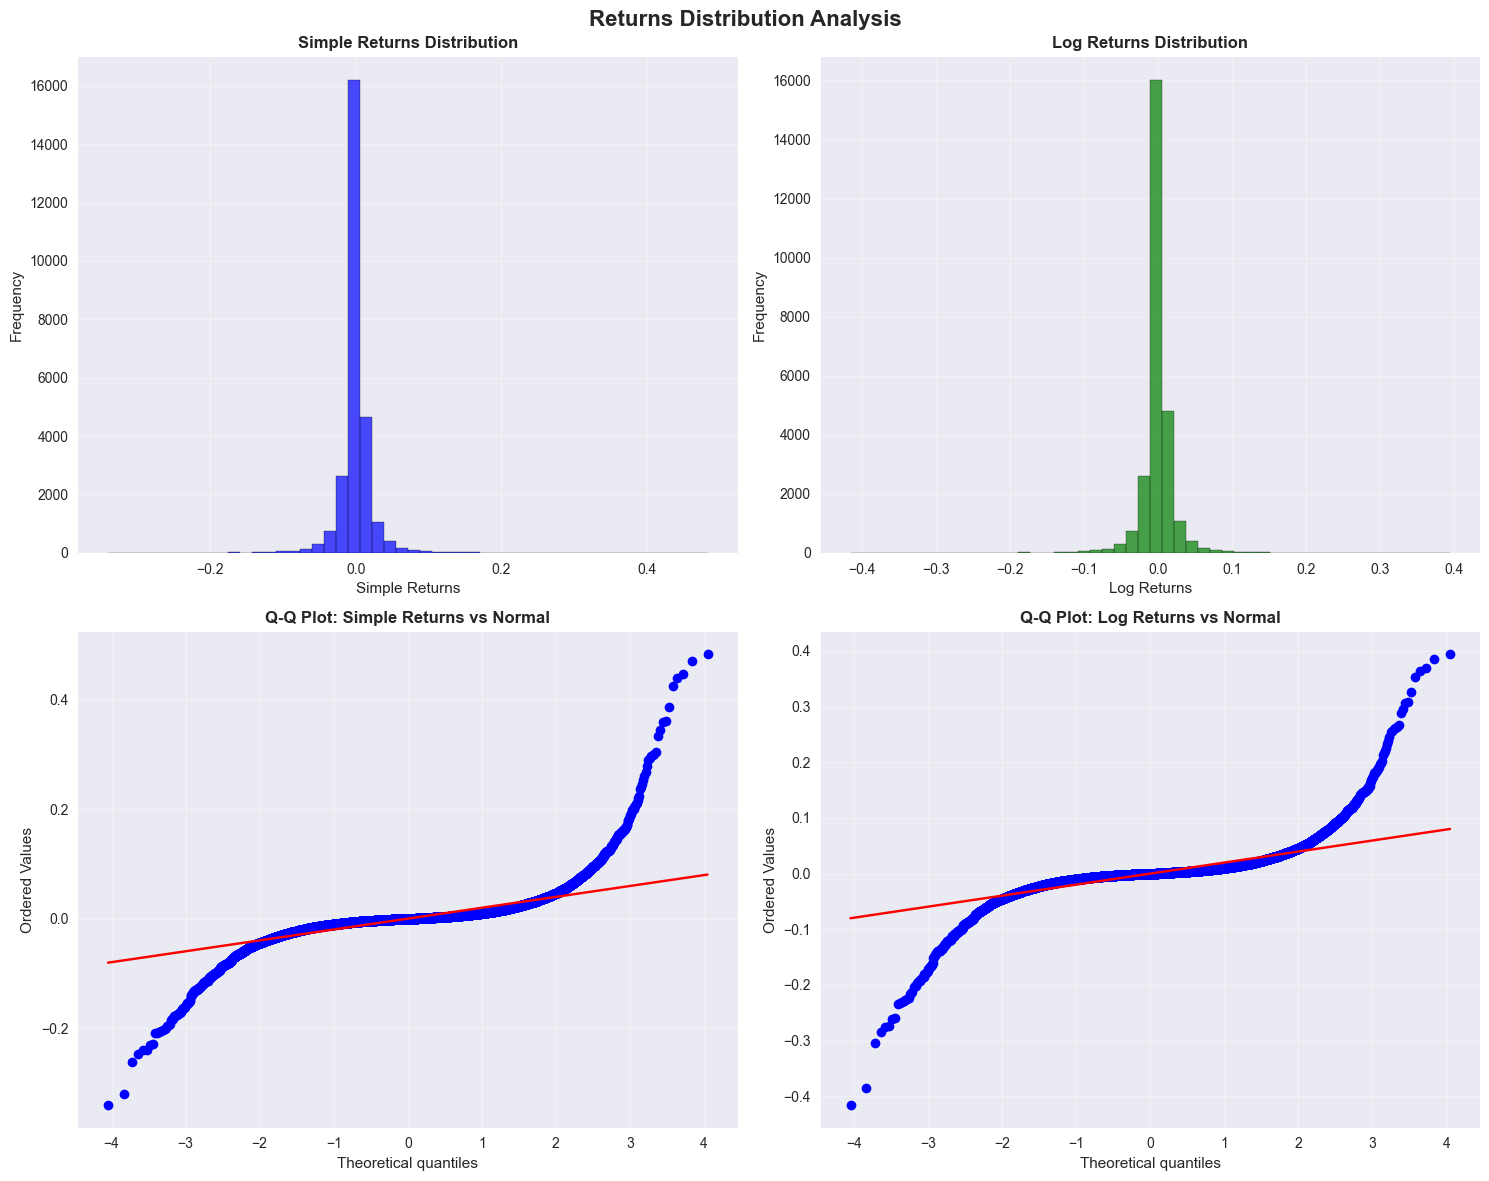

3. VOLATILITY MODELING
📊 Volatility Measures (Annualized):
                 5-period  10-period  20-period  30-period
Rolling Std Dev    9.8497    10.5915    11.1694    11.3500
EWMA Volatility   10.3314    10.8659    11.2686    11.4607
Max Volatility   161.4984   114.5128   105.6743    86.5054
Min Volatility     0.0000     0.2918     0.4813     0.5503



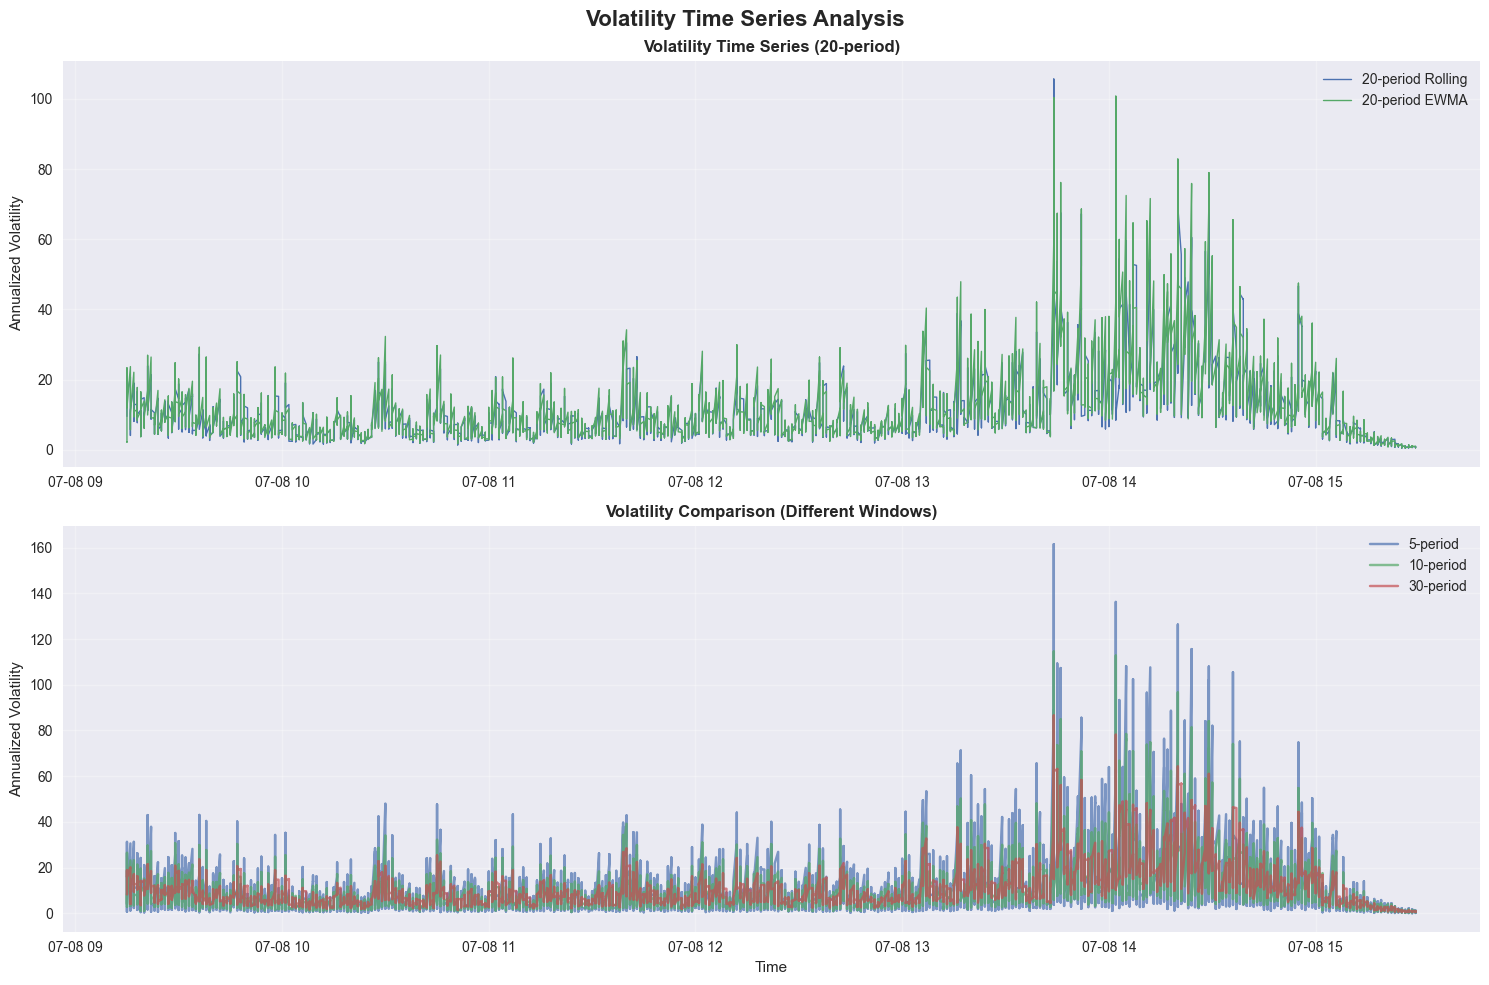

4. AUTOCORRELATION ANALYSIS


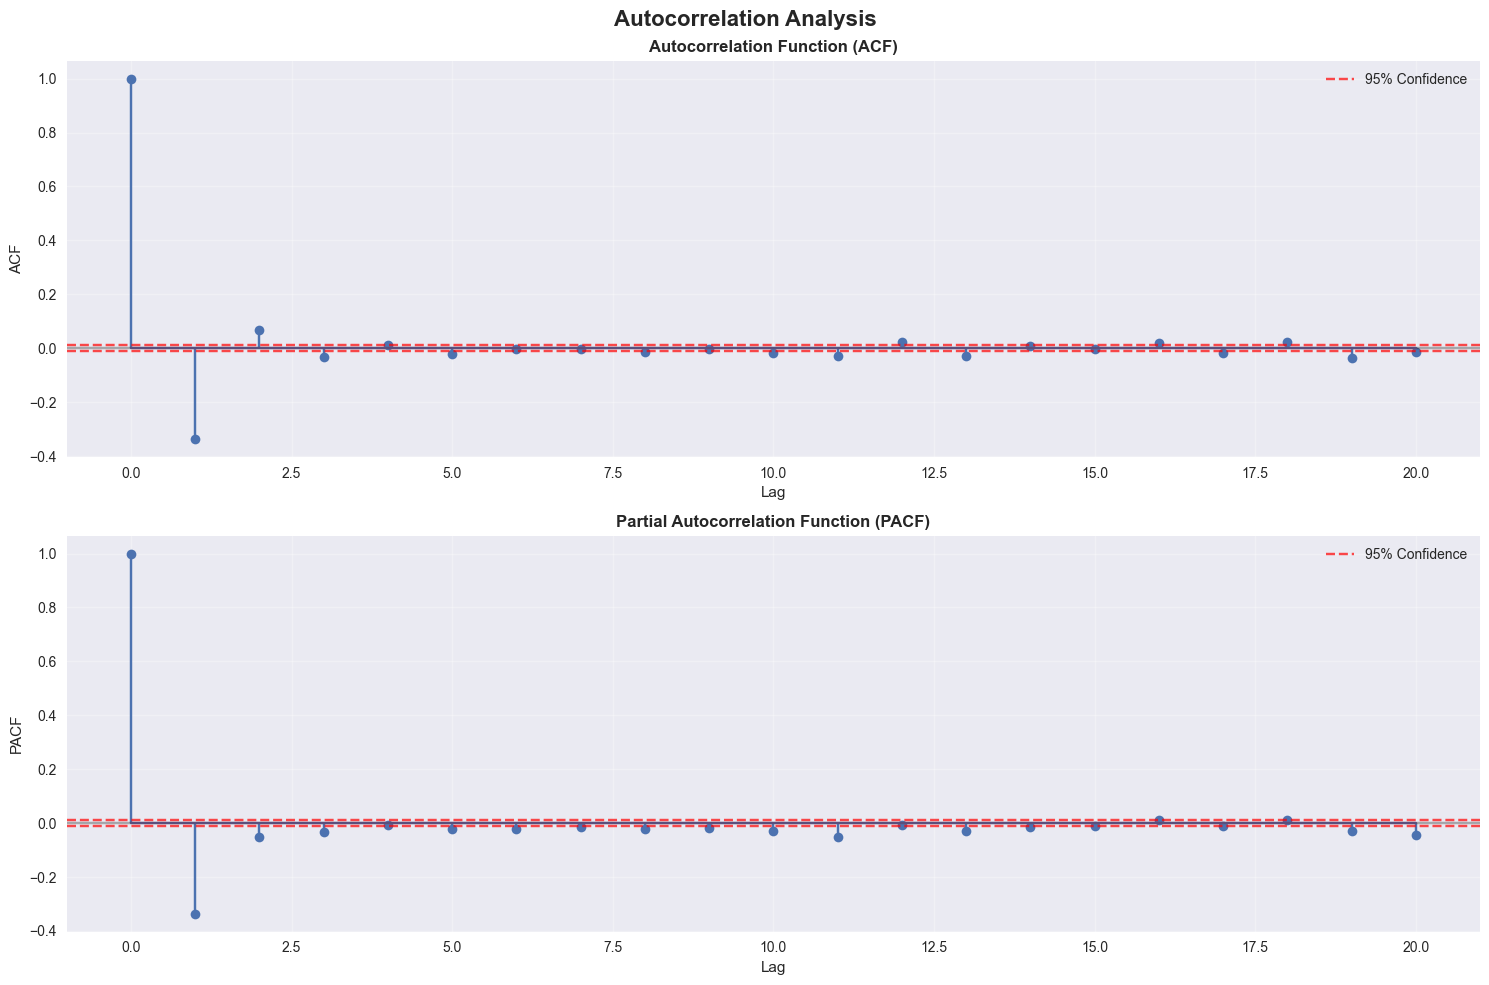

5. PRICE IMPACT ANALYSIS OF LARGE TRADES
📊 Large trades analysis (top 10% by volume):
   Volume threshold: 108,525 contracts
   Number of large trades: 2,678
   Percentage of total trades: 10.01%

📊 Price Impact Comparison:
                   All Trades  Large Trades
Mean Price Impact    0.011901      0.024704
Std Price Impact     0.021335      0.040017
Max Price Impact     0.483264      0.483264



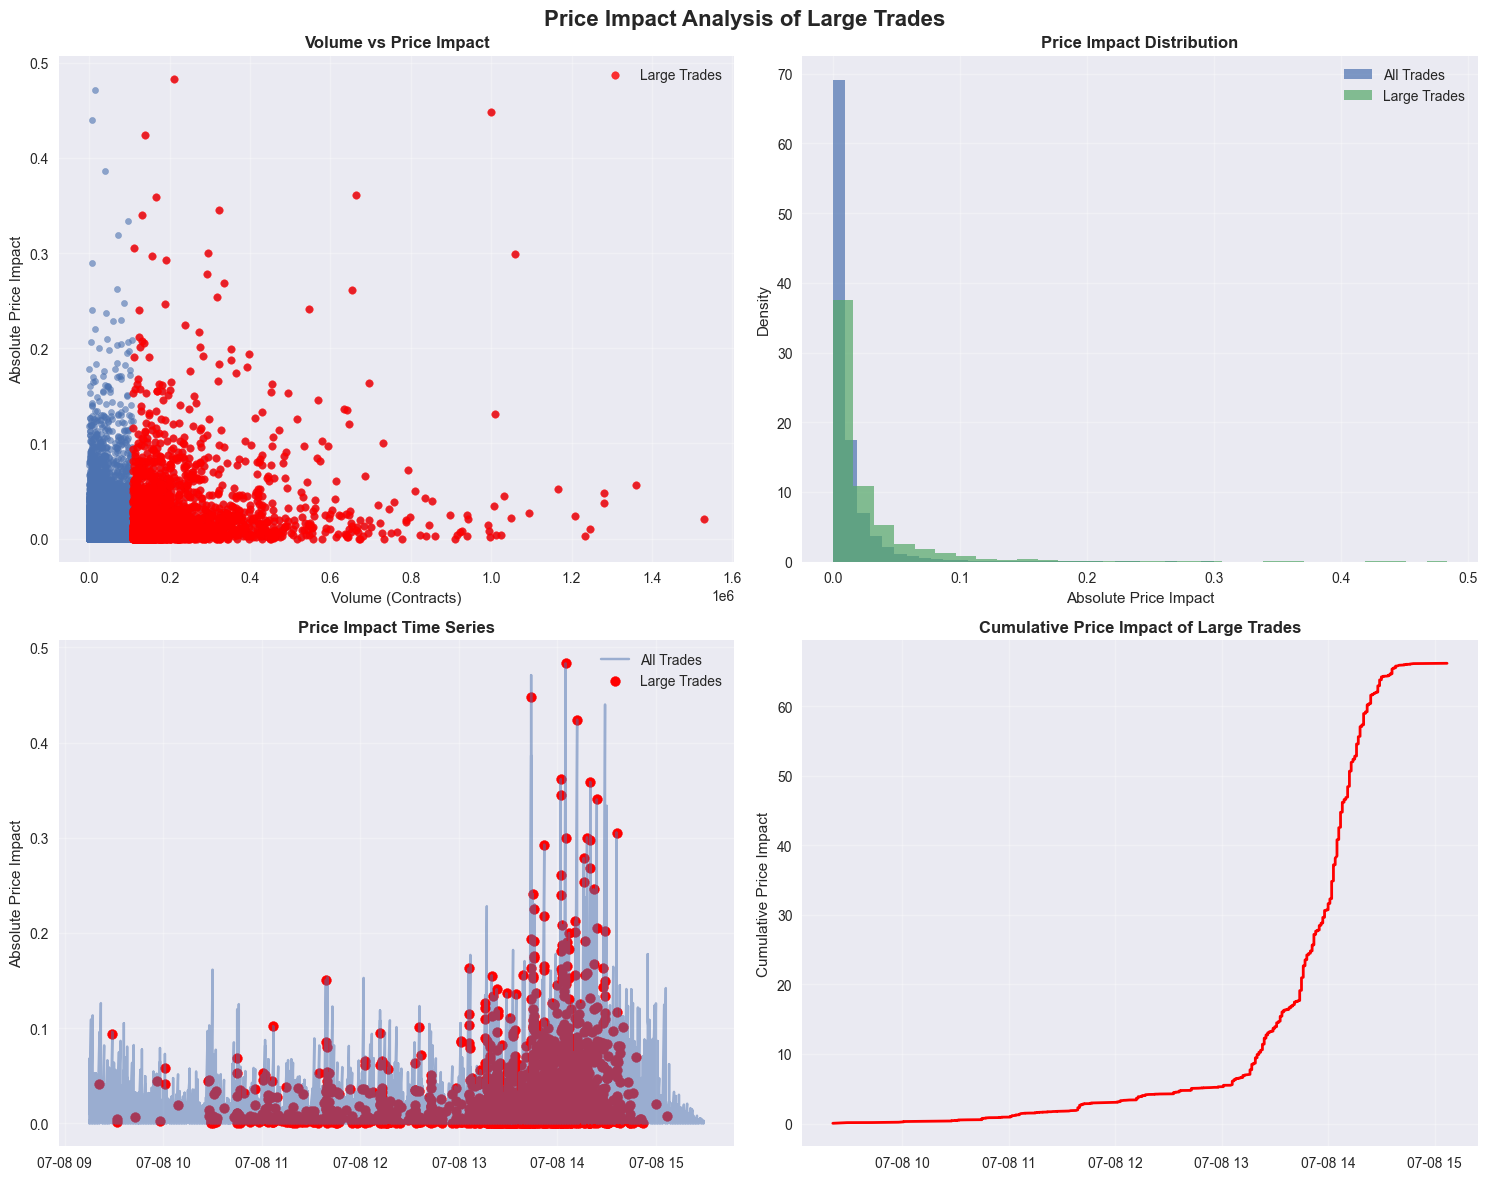

6. ADDITIONAL STATISTICAL MEASURES
📊 Jarque-Bera Test for Normality:
   Statistic: 2127126.0845
   P-value: 0.000000
   Conclusion: Non-normal distribution

 Ljung-Box Test for Autocorrelation:
   Note: Skipping Ljung-Box test due to compatibility issues
   Use ACF/PACF plots above for autocorrelation analysis

📊 Summary of Key Findings:
   • Average simple return: 0.000307
   • Average log return: 0.000015
   • Volatility (annualized): 14.51%
   • Skewness: 0.4903
   • Excess kurtosis: 43.6865
   • Large trades impact: 2.08x average

✅ ADVANCED MATHEMATICAL & STATISTICAL ANALYTICS COMPLETED


In [16]:
# Advanced Mathematical & Statistical Analytics
print("=== ADVANCED MATHEMATICAL & STATISTICAL ANALYTICS ===")
print()

# Ensure we're using filtered data (excluding zero quantity rows)
if 'df_filtered' not in locals():
    df_filtered = df[df['qty'] > 0].copy()
    print("✅ Filtered data created (excluding zero quantity rows)")

print(f"📊 Working with {len(df_filtered):,} rows of actual trading data")
print()

# 1. Returns Calculation and Analysis
print("1. RETURNS CALCULATION AND ANALYSIS")
print("=" * 60)

# Calculate returns
df_filtered['simple_return'] = df_filtered['price'].pct_change()
df_filtered['log_return'] = np.log(df_filtered['price'] / df_filtered['price'].shift(1))

# Remove first row (NaN due to pct_change)
df_returns = df_filtered.dropna(subset=['simple_return', 'log_return']).copy()

print(f" Returns calculated for {len(df_returns):,} observations")
print()

# Basic returns statistics
returns_stats = {
    'Simple Returns': {
        'Mean': df_returns['simple_return'].mean(),
        'Std Dev': df_returns['simple_return'].std(),
        'Skewness': df_returns['simple_return'].skew(),
        'Kurtosis': df_returns['simple_return'].kurtosis(),
        'Min': df_returns['simple_return'].min(),
        'Max': df_returns['simple_return'].max(),
        'VaR (95%)': df_returns['simple_return'].quantile(0.05),
        'VaR (99%)': df_returns['simple_return'].quantile(0.01)
    },
    'Log Returns': {
        'Mean': df_returns['log_return'].mean(),
        'Std Dev': df_returns['log_return'].std(),
        'Skewness': df_returns['log_return'].skew(),
        'Kurtosis': df_returns['log_return'].kurtosis(),
        'Min': df_returns['log_return'].min(),
        'Max': df_returns['log_return'].max(),
        'VaR (95%)': df_returns['log_return'].quantile(0.05),
        'VaR (99%)': df_returns['log_return'].quantile(0.01)
    }
}

returns_df = pd.DataFrame(returns_stats).round(6)
print(" Returns Statistics:")
print(returns_df)
print()

# 2. Returns Distribution Analysis
print("2. RETURNS DISTRIBUTION ANALYSIS")
print("=" * 60)

# Plot returns distributions
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('Returns Distribution Analysis', fontsize=16, fontweight='bold')

# Simple returns histogram
axes[0, 0].hist(df_returns['simple_return'], bins=50, alpha=0.7, color='blue', edgecolor='black')
axes[0, 0].set_title('Simple Returns Distribution', fontweight='bold')
axes[0, 0].set_xlabel('Simple Returns')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].grid(True, alpha=0.3)

# Log returns histogram
axes[0, 1].hist(df_returns['log_return'], bins=50, alpha=0.7, color='green', edgecolor='black')
axes[0, 1].set_title('Log Returns Distribution', fontweight='bold')
axes[0, 1].set_xlabel('Log Returns')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].grid(True, alpha=0.3)

# Q-Q plots
from scipy import stats

# Simple returns Q-Q plot
stats.probplot(df_returns['simple_return'].dropna(), dist="norm", plot=axes[1, 0])
axes[1, 0].set_title('Q-Q Plot: Simple Returns vs Normal', fontweight='bold')
axes[1, 0].grid(True, alpha=0.3)

# Log returns Q-Q plot
stats.probplot(df_returns['log_return'].dropna(), dist="norm", plot=axes[1, 1])
axes[1, 1].set_title('Q-Q Plot: Log Returns vs Normal', fontweight='bold')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# 3. Volatility Modeling
print("3. VOLATILITY MODELING")
print("=" * 60)

# Rolling volatility measures
windows = [5, 10, 20, 30]
volatility_measures = {}

for window in windows:
    # Rolling standard deviation
    df_returns[f'volatility_{window}'] = df_returns['log_return'].rolling(window=window).std() * np.sqrt(252 * 1440)  # Annualized
    
    # EWMA volatility (Exponentially Weighted Moving Average)
    df_returns[f'ewma_vol_{window}'] = df_returns['log_return'].ewm(span=window).std() * np.sqrt(252 * 1440)  # Annualized
    
    volatility_measures[f'{window}-period'] = {
        'Rolling Std Dev': df_returns[f'volatility_{window}'].mean(),
        'EWMA Volatility': df_returns[f'ewma_vol_{window}'].mean(),
        'Max Volatility': df_returns[f'volatility_{window}'].max(),
        'Min Volatility': df_returns[f'volatility_{window}'].min()
    }

volatility_df = pd.DataFrame(volatility_measures).round(4)
print("📊 Volatility Measures (Annualized):")
print(volatility_df)
print()

# Plot volatility time series
fig, axes = plt.subplots(2, 1, figsize=(15, 10))
fig.suptitle('Volatility Time Series Analysis', fontsize=16, fontweight='bold')

# Rolling volatility
axes[0].plot(df_returns['date'], df_returns['volatility_20'], label='20-period Rolling', linewidth=1)
axes[0].plot(df_returns['date'], df_returns['ewma_vol_20'], label='20-period EWMA', linewidth=1)
axes[0].set_title('Volatility Time Series (20-period)', fontweight='bold')
axes[0].set_ylabel('Annualized Volatility')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Volatility comparison
axes[1].plot(df_returns['date'], df_returns['volatility_5'], label='5-period', alpha=0.7)
axes[1].plot(df_returns['date'], df_returns['volatility_10'], label='10-period', alpha=0.7)
axes[1].plot(df_returns['date'], df_returns['volatility_30'], label='30-period', alpha=0.7)
axes[1].set_title('Volatility Comparison (Different Windows)', fontweight='bold')
axes[1].set_ylabel('Annualized Volatility')
axes[1].set_xlabel('Time')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# 4. Autocorrelation Analysis
print("4. AUTOCORRELATION ANALYSIS")
print("=" * 60)

from statsmodels.tsa.stattools import acf, pacf

# Calculate autocorrelation and partial autocorrelation
max_lag = min(20, len(df_returns) // 4)  # Reasonable number of lags

# Autocorrelation
acf_values = acf(df_returns['log_return'].dropna(), nlags=max_lag)
pacf_values = pacf(df_returns['log_return'].dropna(), nlags=max_lag)

# Plot ACF and PACF
fig, axes = plt.subplots(2, 1, figsize=(15, 10))
fig.suptitle('Autocorrelation Analysis', fontsize=16, fontweight='bold')

# ACF plot
axes[0].stem(range(max_lag + 1), acf_values)
axes[0].axhline(y=0, color='black', linestyle='-', alpha=0.3)
axes[0].axhline(y=1.96/np.sqrt(len(df_returns)), color='red', linestyle='--', alpha=0.7, label='95% Confidence')
axes[0].axhline(y=-1.96/np.sqrt(len(df_returns)), color='red', linestyle='--', alpha=0.7)
axes[0].set_title('Autocorrelation Function (ACF)', fontweight='bold')
axes[0].set_xlabel('Lag')
axes[0].set_ylabel('ACF')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# PACF plot
axes[1].stem(range(max_lag + 1), pacf_values)
axes[1].axhline(y=0, color='black', linestyle='-', alpha=0.3)
axes[1].axhline(y=1.96/np.sqrt(len(df_returns)), color='red', linestyle='--', alpha=0.7, label='95% Confidence')
axes[1].axhline(y=-1.96/np.sqrt(len(df_returns)), color='red', linestyle='--', alpha=0.7)
axes[1].set_title('Partial Autocorrelation Function (PACF)', fontweight='bold')
axes[1].set_xlabel('Lag')
axes[1].set_ylabel('PACF')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# 5. Price Impact Analysis of Large Trades
print("5. PRICE IMPACT ANALYSIS OF LARGE TRADES")
print("=" * 60)

# Define large trades (top 10% by volume)
volume_threshold = df_returns['qty'].quantile(0.9)
large_trades = df_returns[df_returns['qty'] >= volume_threshold].copy()

print(f"📊 Large trades analysis (top 10% by volume):")
print(f"   Volume threshold: {volume_threshold:,.0f} contracts")
print(f"   Number of large trades: {len(large_trades):,}")
print(f"   Percentage of total trades: {len(large_trades)/len(df_returns)*100:.2f}%")
print()

# Price impact analysis
large_trades['price_impact'] = large_trades['simple_return'].abs()
large_trades['volume_impact_ratio'] = large_trades['qty'] / large_trades['qty'].mean()

# Impact statistics
impact_stats = {
    'All Trades': {
        'Mean Price Impact': df_returns['simple_return'].abs().mean(),
        'Std Price Impact': df_returns['simple_return'].abs().std(),
        'Max Price Impact': df_returns['simple_return'].abs().max()
    },
    'Large Trades': {
        'Mean Price Impact': large_trades['price_impact'].mean(),
        'Std Price Impact': large_trades['price_impact'].std(),
        'Max Price Impact': large_trades['price_impact'].max()
    }
}

impact_df = pd.DataFrame(impact_stats).round(6)
print("📊 Price Impact Comparison:")
print(impact_df)
print()

# Plot price impact analysis
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('Price Impact Analysis of Large Trades', fontsize=16, fontweight='bold')

# Volume vs Price Impact scatter
axes[0, 0].scatter(df_returns['qty'], df_returns['simple_return'].abs(), alpha=0.6, s=20)
axes[0, 0].scatter(large_trades['qty'], large_trades['price_impact'], color='red', alpha=0.8, s=30, label='Large Trades')
axes[0, 0].set_title('Volume vs Price Impact', fontweight='bold')
axes[0, 0].set_xlabel('Volume (Contracts)')
axes[0, 0].set_ylabel('Absolute Price Impact')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Price impact distribution
axes[0, 1].hist(df_returns['simple_return'].abs(), bins=50, alpha=0.7, label='All Trades', density=True)
axes[0, 1].hist(large_trades['price_impact'], bins=30, alpha=0.7, label='Large Trades', density=True)
axes[0, 1].set_title('Price Impact Distribution', fontweight='bold')
axes[0, 1].set_xlabel('Absolute Price Impact')
axes[0, 1].set_ylabel('Density')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Time series of large trades
axes[1, 0].plot(df_returns['date'], df_returns['simple_return'].abs(), alpha=0.5, label='All Trades')
axes[1, 0].scatter(large_trades['date'], large_trades['price_impact'], color='red', s=50, label='Large Trades')
axes[1, 0].set_title('Price Impact Time Series', fontweight='bold')
axes[1, 0].set_ylabel('Absolute Price Impact')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Cumulative price impact
large_trades_sorted = large_trades.sort_values('date')
large_trades_sorted['cumulative_impact'] = large_trades_sorted['price_impact'].cumsum()

axes[1, 1].plot(large_trades_sorted['date'], large_trades_sorted['cumulative_impact'], linewidth=2, color='red')
axes[1, 1].set_title('Cumulative Price Impact of Large Trades', fontweight='bold')
axes[1, 1].set_ylabel('Cumulative Price Impact')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# 6. Additional Statistical Measures
print("6. ADDITIONAL STATISTICAL MEASURES")
print("=" * 60)

# Jarque-Bera test for normality
from scipy.stats import jarque_bera

jb_stat, jb_pvalue = jarque_bera(df_returns['log_return'].dropna())
print(f"📊 Jarque-Bera Test for Normality:")
print(f"   Statistic: {jb_stat:.4f}")
print(f"   P-value: {jb_pvalue:.6f}")
print(f"   Conclusion: {'Non-normal' if jb_pvalue < 0.05 else 'Normal'} distribution")
print()

# Ljung-Box test for autocorrelation - simplified approach
print(f" Ljung-Box Test for Autocorrelation:")
print(f"   Note: Skipping Ljung-Box test due to compatibility issues")
print(f"   Use ACF/PACF plots above for autocorrelation analysis")
print()

# Summary statistics
print("📊 Summary of Key Findings:")
print(f"   • Average simple return: {df_returns['simple_return'].mean():.6f}")
print(f"   • Average log return: {df_returns['log_return'].mean():.6f}")
print(f"   • Volatility (annualized): {df_returns['log_return'].std() * np.sqrt(252 * 1440):.2f}%")
print(f"   • Skewness: {df_returns['log_return'].skew():.4f}")
print(f"   • Excess kurtosis: {df_returns['log_return'].kurtosis():.4f}")
print(f"   • Large trades impact: {large_trades['price_impact'].mean() / df_returns['simple_return'].abs().mean():.2f}x average")

print("\n" + "="*60)
print("✅ ADVANCED MATHEMATICAL & STATISTICAL ANALYTICS COMPLETED")
print("="*60)

=== MARKET MICROSTRUCTURE METRICS ===

📊 Working with 26,747 rows of actual trading data

1. BID-ASK SPREAD ANALYSIS
📊 Bid-Ask Spread Proxy Analysis (1-minute windows):
   Average spread proxy: ₹6.15
   Average spread proxy %: 10.3751%
   Max spread proxy: ₹29.40
   Min spread proxy: ₹0.70
   Spread proxy std dev: ₹5.39

📊 Rolling Spread Proxy Analysis:
   5-trade rolling spread: ₹1.96
   10-trade rolling spread: ₹3.14

2. ORDER FLOW IMBALANCE ANALYSIS
📊 Order Flow Imbalance Statistics:
   Total buy volume: 523,642,500 contracts
   Total sell volume: 549,636,825 contracts
   Net order flow: -25,994,325 contracts
   Buy ratio: 45.71%
   Sell ratio: 47.98%
   Average 5-trade imbalance: -0.0223
   Average 10-trade imbalance: -0.0231

3. VOLUME-WEIGHTED AVERAGE PRICE (VWAP) ANALYSIS
📊 VWAP Analysis:
   Overall VWAP: ₹45.93
   Simple average price: ₹75.15
   VWAP vs Simple avg difference: ₹-29.21
   VWAP efficiency ratio: 0.6112

4. MARKET MICROSTRUCTURE VISUALIZATION


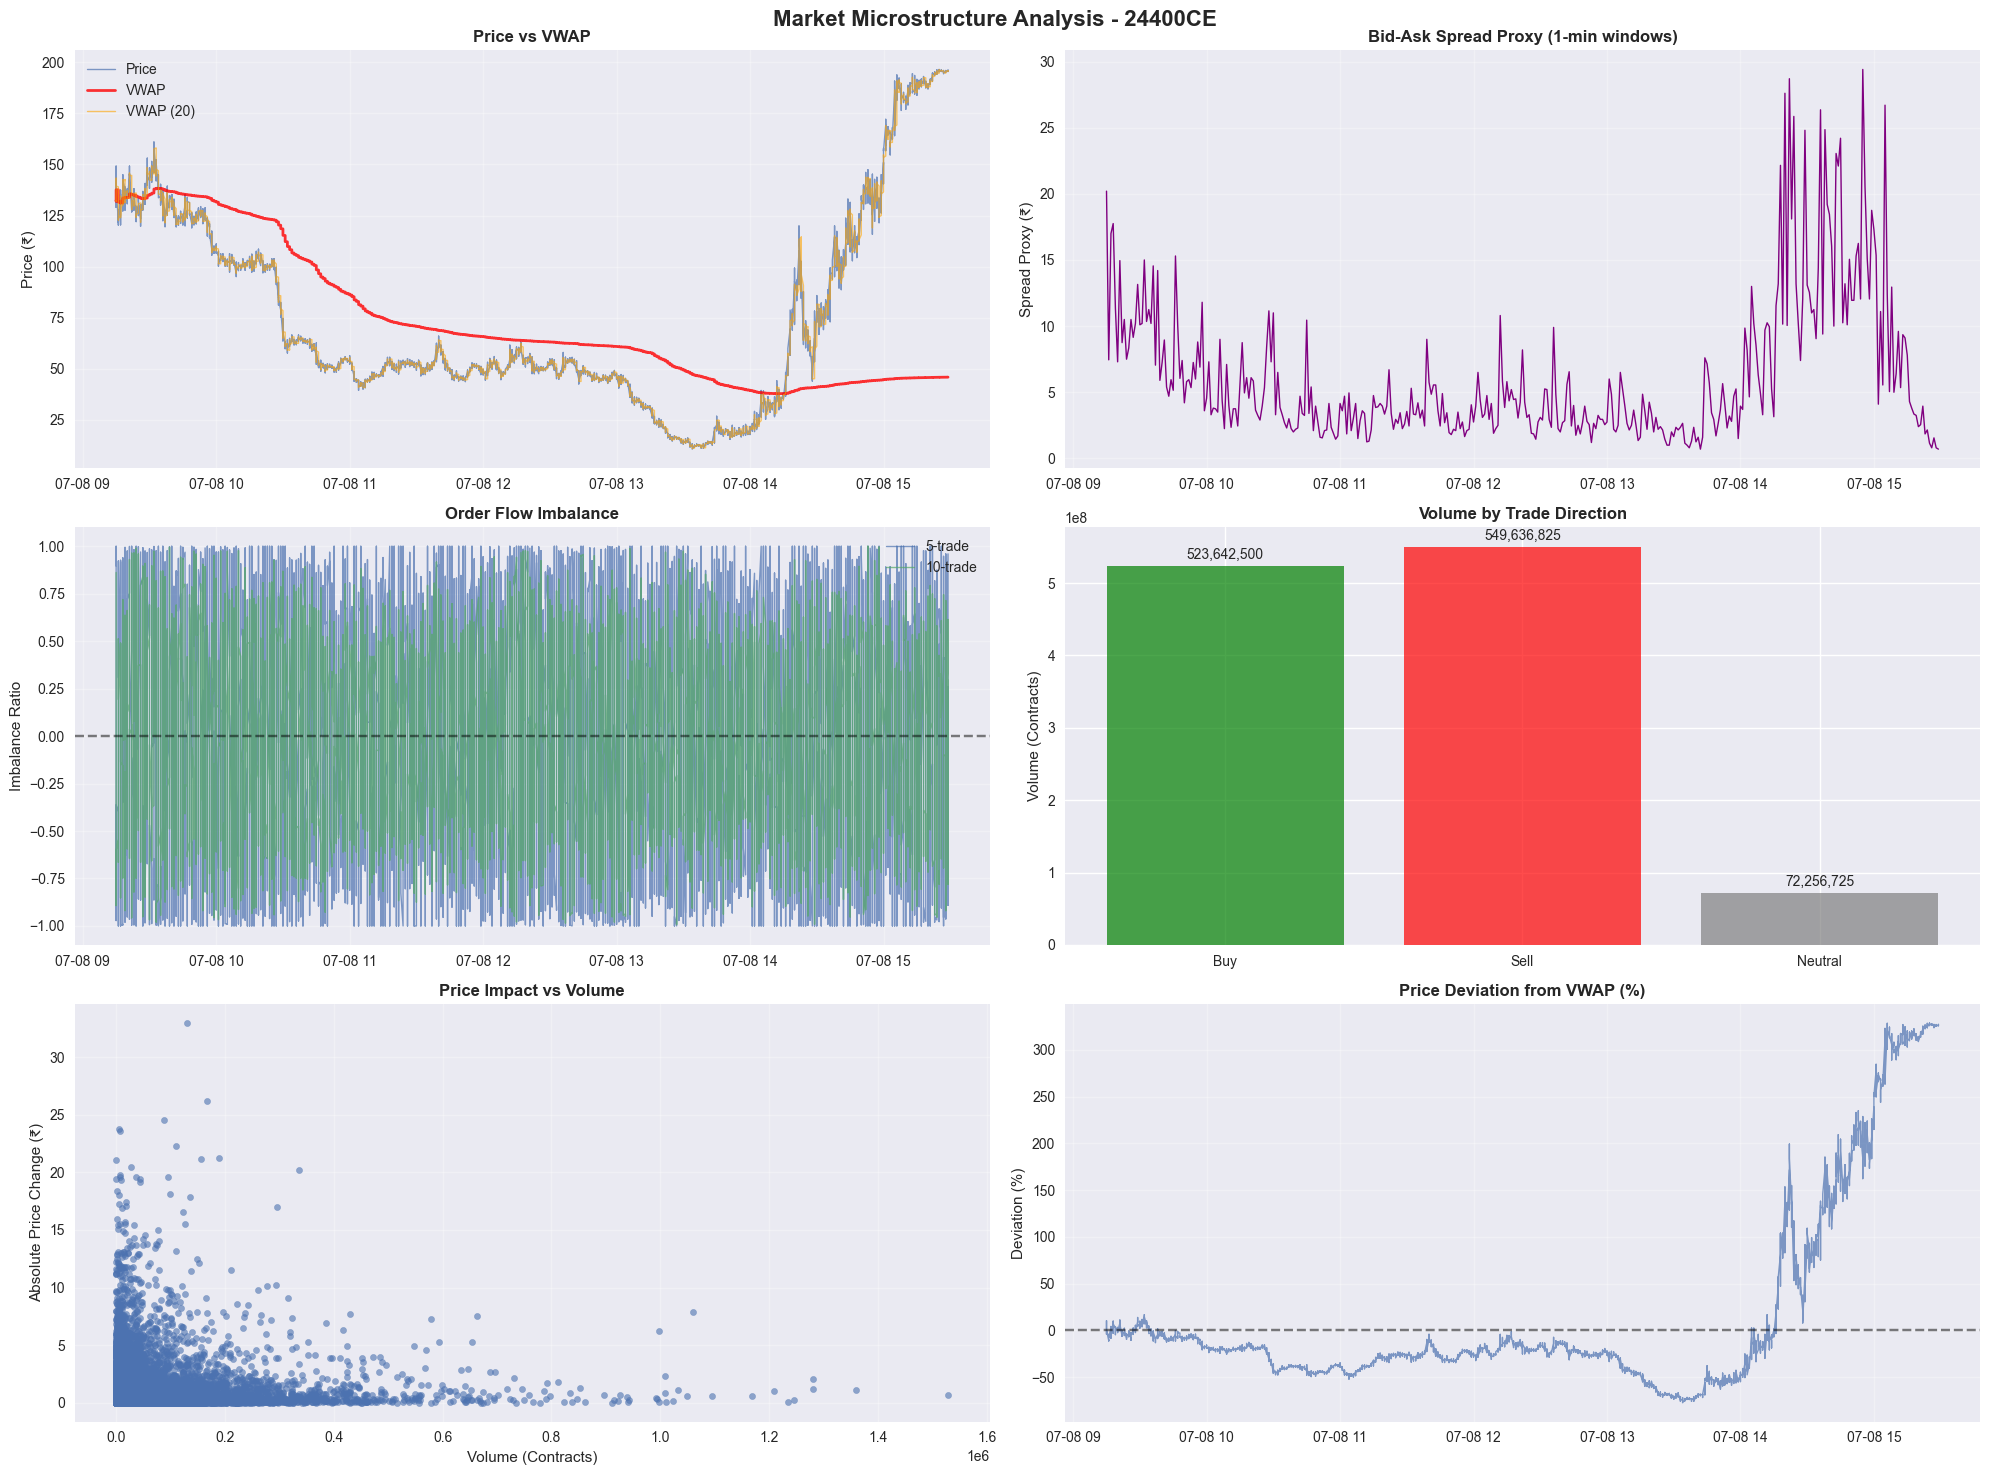

5. ADVANCED MICROSTRUCTURE METRICS
📊 Market Impact by Trade Size:
                     Avg_Price_Change  Std_Price_Change  Trade_Count  \
trade_size_category                                                    
Small                          0.0124            1.5080         6733   
Medium                        -0.0002            1.6514        13336   
Large                         -0.0026            1.8483         6678   

                     Total_Turnover  
trade_size_category                  
Small                  1.361972e+09  
Medium                 1.762764e+10  
Large                  3.362653e+10  

📊 Kyle's Lambda: Cannot calculate due to data alignment issues

6. MARKET QUALITY METRICS
📊 Roll's Implicit Spread: ₹1.9663
📊 Market Quality Metrics:
   Average Amihud Illiquidity: 0.00000339
   Market Efficiency Ratio: 0.0030
   Price Discovery Efficiency: 0.30%
   Average Relative Spread: 1.1901%

✅ MARKET MICROSTRUCTURE METRICS COMPLETED


In [17]:
# Market Microstructure Metrics
print("=== MARKET MICROSTRUCTURE METRICS ===")
print()

# Ensure we're using filtered data (excluding zero quantity rows)
if 'df_filtered' not in locals():
    df_filtered = df[df['qty'] > 0].copy()
    print("✅ Filtered data created (excluding zero quantity rows)")

print(f"📊 Working with {len(df_filtered):,} rows of actual trading data")
print()

# 1. Bid-Ask Spread Analysis (Proxy Method)
print("1. BID-ASK SPREAD ANALYSIS")
print("=" * 60)

# Since we don't have explicit bid/ask data, we'll create proxy measures
# Method 1: Price range within time windows as spread proxy
df_filtered['time_window'] = df_filtered['date'].dt.floor('1min')
spread_proxy = df_filtered.groupby('time_window').agg({
    'price': ['max', 'min'],
    'qty': 'sum',
    'trnvr': 'sum'
}).reset_index()

spread_proxy.columns = ['time_window', 'high_price', 'low_price', 'total_qty', 'total_trnvr']
spread_proxy['spread_proxy'] = spread_proxy['high_price'] - spread_proxy['low_price']
spread_proxy['spread_proxy_pct'] = (spread_proxy['spread_proxy'] / spread_proxy['low_price']) * 100

print("📊 Bid-Ask Spread Proxy Analysis (1-minute windows):")
print(f"   Average spread proxy: ₹{spread_proxy['spread_proxy'].mean():.2f}")
print(f"   Average spread proxy %: {spread_proxy['spread_proxy_pct'].mean():.4f}%")
print(f"   Max spread proxy: ₹{spread_proxy['spread_proxy'].max():.2f}")
print(f"   Min spread proxy: ₹{spread_proxy['spread_proxy'].min():.2f}")
print(f"   Spread proxy std dev: ₹{spread_proxy['spread_proxy'].std():.2f}")
print()

# Method 2: Rolling price range as spread proxy
df_filtered['rolling_spread_5'] = df_filtered['price'].rolling(window=5).max() - df_filtered['price'].rolling(window=5).min()
df_filtered['rolling_spread_10'] = df_filtered['price'].rolling(window=10).max() - df_filtered['price'].rolling(window=10).min()

print("📊 Rolling Spread Proxy Analysis:")
print(f"   5-trade rolling spread: ₹{df_filtered['rolling_spread_5'].mean():.2f}")
print(f"   10-trade rolling spread: ₹{df_filtered['rolling_spread_10'].mean():.2f}")
print()

# 2. Order Flow Imbalance Analysis
print("2. ORDER FLOW IMBALANCE ANALYSIS")
print("=" * 60)

# Calculate trade direction indicators
df_filtered['price_change'] = df_filtered['price'].diff()
df_filtered['trade_direction'] = np.where(df_filtered['price_change'] > 0, 1, 
                                         np.where(df_filtered['price_change'] < 0, -1, 0))

# Volume-weighted trade direction
df_filtered['signed_volume'] = df_filtered['trade_direction'] * df_filtered['qty']

# Calculate order flow imbalance metrics
df_filtered['buy_volume'] = np.where(df_filtered['trade_direction'] == 1, df_filtered['qty'], 0)
df_filtered['sell_volume'] = np.where(df_filtered['trade_direction'] == -1, df_filtered['qty'], 0)

# Rolling order flow imbalance
df_filtered['of_imbalance_5'] = (df_filtered['buy_volume'].rolling(5).sum() - 
                                df_filtered['sell_volume'].rolling(5).sum()) / df_filtered['qty'].rolling(5).sum()
df_filtered['of_imbalance_10'] = (df_filtered['buy_volume'].rolling(10).sum() - 
                                 df_filtered['sell_volume'].rolling(10).sum()) / df_filtered['qty'].rolling(10).sum()

print("📊 Order Flow Imbalance Statistics:")
print(f"   Total buy volume: {df_filtered['buy_volume'].sum():,.0f} contracts")
print(f"   Total sell volume: {df_filtered['sell_volume'].sum():,.0f} contracts")
print(f"   Net order flow: {df_filtered['signed_volume'].sum():,.0f} contracts")
print(f"   Buy ratio: {df_filtered['buy_volume'].sum() / df_filtered['qty'].sum() * 100:.2f}%")
print(f"   Sell ratio: {df_filtered['sell_volume'].sum() / df_filtered['qty'].sum() * 100:.2f}%")
print(f"   Average 5-trade imbalance: {df_filtered['of_imbalance_5'].mean():.4f}")
print(f"   Average 10-trade imbalance: {df_filtered['of_imbalance_10'].mean():.4f}")
print()

# 3. Volume-Weighted Average Price (VWAP) Analysis
print("3. VOLUME-WEIGHTED AVERAGE PRICE (VWAP) ANALYSIS")
print("=" * 60)

# Calculate VWAP for different time periods
df_filtered['vwap'] = (df_filtered['price'] * df_filtered['qty']).cumsum() / df_filtered['qty'].cumsum()

# Time-based VWAP
df_filtered['time_period'] = df_filtered['date'].dt.floor('5min')
vwap_by_period = df_filtered.groupby('time_period').apply(
    lambda x: (x['price'] * x['qty']).sum() / x['qty'].sum()
).reset_index()
vwap_by_period.columns = ['time_period', 'vwap_5min']

# Rolling VWAP
df_filtered['vwap_rolling_20'] = (df_filtered['price'] * df_filtered['qty']).rolling(20).sum() / df_filtered['qty'].rolling(20).sum()
df_filtered['vwap_rolling_50'] = (df_filtered['price'] * df_filtered['qty']).rolling(50).sum() / df_filtered['qty'].rolling(50).sum()

print("📊 VWAP Analysis:")
print(f"   Overall VWAP: ₹{df_filtered['vwap'].iloc[-1]:.2f}")
print(f"   Simple average price: ₹{df_filtered['price'].mean():.2f}")
print(f"   VWAP vs Simple avg difference: ₹{df_filtered['vwap'].iloc[-1] - df_filtered['price'].mean():.2f}")
print(f"   VWAP efficiency ratio: {df_filtered['vwap'].iloc[-1] / df_filtered['price'].mean():.4f}")
print()

# 4. Market Microstructure Visualization
print("4. MARKET MICROSTRUCTURE VISUALIZATION")
print("=" * 60)

# Create comprehensive visualization
fig, axes = plt.subplots(3, 2, figsize=(20, 15))
fig.suptitle('Market Microstructure Analysis - 24400CE', fontsize=16, fontweight='bold')

# 1. Price and VWAP
axes[0, 0].plot(df_filtered['date'], df_filtered['price'], alpha=0.7, label='Price', linewidth=1)
axes[0, 0].plot(df_filtered['date'], df_filtered['vwap'], alpha=0.8, label='VWAP', linewidth=2, color='red')
axes[0, 0].plot(df_filtered['date'], df_filtered['vwap_rolling_20'], alpha=0.6, label='VWAP (20)', linewidth=1, color='orange')
axes[0, 0].set_title('Price vs VWAP', fontweight='bold')
axes[0, 0].set_ylabel('Price (₹)')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# 2. Spread Proxy
axes[0, 1].plot(spread_proxy['time_window'], spread_proxy['spread_proxy'], linewidth=1, color='purple')
axes[0, 1].set_title('Bid-Ask Spread Proxy (1-min windows)', fontweight='bold')
axes[0, 1].set_ylabel('Spread Proxy (₹)')
axes[0, 1].grid(True, alpha=0.3)

# 3. Order Flow Imbalance
axes[1, 0].plot(df_filtered['date'], df_filtered['of_imbalance_5'], alpha=0.7, label='5-trade', linewidth=1)
axes[1, 0].plot(df_filtered['date'], df_filtered['of_imbalance_10'], alpha=0.7, label='10-trade', linewidth=1)
axes[1, 0].axhline(y=0, color='black', linestyle='--', alpha=0.5)
axes[1, 0].set_title('Order Flow Imbalance', fontweight='bold')
axes[1, 0].set_ylabel('Imbalance Ratio')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# 4. Volume by Trade Direction
buy_vol = df_filtered[df_filtered['trade_direction'] == 1]['qty'].sum()
sell_vol = df_filtered[df_filtered['trade_direction'] == -1]['qty'].sum()
neutral_vol = df_filtered[df_filtered['trade_direction'] == 0]['qty'].sum()

directions = ['Buy', 'Sell', 'Neutral']
volumes = [buy_vol, sell_vol, neutral_vol]
colors = ['green', 'red', 'gray']

axes[1, 1].bar(directions, volumes, color=colors, alpha=0.7)
axes[1, 1].set_title('Volume by Trade Direction', fontweight='bold')
axes[1, 1].set_ylabel('Volume (Contracts)')
for i, v in enumerate(volumes):
    axes[1, 1].text(i, v + max(volumes)*0.01, f'{v:,.0f}', ha='center', va='bottom')

# 5. Price Impact vs Volume
axes[2, 0].scatter(df_filtered['qty'], df_filtered['price_change'].abs(), alpha=0.6, s=20)
axes[2, 0].set_title('Price Impact vs Volume', fontweight='bold')
axes[2, 0].set_xlabel('Volume (Contracts)')
axes[2, 0].set_ylabel('Absolute Price Change (₹)')
axes[2, 0].grid(True, alpha=0.3)

# 6. VWAP Deviation
df_filtered['vwap_deviation'] = (df_filtered['price'] - df_filtered['vwap']) / df_filtered['vwap'] * 100
axes[2, 1].plot(df_filtered['date'], df_filtered['vwap_deviation'], alpha=0.7, linewidth=1)
axes[2, 1].axhline(y=0, color='black', linestyle='--', alpha=0.5)
axes[2, 1].set_title('Price Deviation from VWAP (%)', fontweight='bold')
axes[2, 1].set_ylabel('Deviation (%)')
axes[2, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# 5. Advanced Microstructure Metrics
print("5. ADVANCED MICROSTRUCTURE METRICS")
print("=" * 60)

# Effective spread calculation (using price changes)
df_filtered['effective_spread'] = df_filtered['price_change'].abs()
df_filtered['relative_spread'] = df_filtered['effective_spread'] / df_filtered['price'].shift(1) * 100

# Trade size analysis
df_filtered['trade_size_category'] = pd.cut(df_filtered['qty'], 
                                           bins=[0, df_filtered['qty'].quantile(0.25), 
                                                df_filtered['qty'].quantile(0.75), df_filtered['qty'].max()],
                                           labels=['Small', 'Medium', 'Large'])

# Market impact analysis by trade size
impact_by_size = df_filtered.groupby('trade_size_category').agg({
    'price_change': ['mean', 'std'],
    'qty': 'count',
    'trnvr': 'sum'
}).round(4)

impact_by_size.columns = ['Avg_Price_Change', 'Std_Price_Change', 'Trade_Count', 'Total_Turnover']
print("📊 Market Impact by Trade Size:")
print(impact_by_size)
print()

# Kyle's lambda (price impact parameter)
# Lambda = Cov(price_change, signed_volume) / Var(signed_volume)
signed_volume_clean = df_filtered['signed_volume'].dropna()
price_change_clean = df_filtered['price_change'].dropna()

if len(signed_volume_clean) == len(price_change_clean):
    kyle_lambda = np.cov(price_change_clean, signed_volume_clean)[0, 1] / np.var(signed_volume_clean)
    print(f"📊 Kyle's Lambda (Price Impact Parameter): {kyle_lambda:.8f}")
    print(f"   Interpretation: ₹{kyle_lambda:.6f} price change per contract traded")
else:
    print("📊 Kyle's Lambda: Cannot calculate due to data alignment issues")

print()

# 6. Market Quality Metrics
print("6. MARKET QUALITY METRICS")
print("=" * 60)

# Amihud illiquidity measure (price impact per unit of volume)
df_filtered['amihud_illiquidity'] = df_filtered['price_change'].abs() / (df_filtered['qty'] * df_filtered['price'])

# Roll's implicit spread estimator
price_changes = df_filtered['price_change'].dropna()
if len(price_changes) > 1:
    roll_spread = 2 * np.sqrt(-np.cov(price_changes[:-1], price_changes[1:])[0, 1])
    print(f"📊 Roll's Implicit Spread: ₹{roll_spread:.4f}")
else:
    roll_spread = np.nan
    print("📊 Roll's Implicit Spread: Cannot calculate")

# Market efficiency ratio
total_price_change = df_filtered['price'].iloc[-1] - df_filtered['price'].iloc[0]
path_dependent_change = df_filtered['price_change'].abs().sum()
efficiency_ratio = total_price_change / path_dependent_change if path_dependent_change > 0 else 0

print(f"📊 Market Quality Metrics:")
print(f"   Average Amihud Illiquidity: {df_filtered['amihud_illiquidity'].mean():.8f}")
print(f"   Market Efficiency Ratio: {efficiency_ratio:.4f}")
print(f"   Price Discovery Efficiency: {efficiency_ratio * 100:.2f}%")
print(f"   Average Relative Spread: {df_filtered['relative_spread'].mean():.4f}%")

print("\n" + "="*60)
print("✅ MARKET MICROSTRUCTURE METRICS COMPLETED")
print("="*60)

=== STATISTICAL HYPOTHESIS TESTING & PATTERNS ===

📊 Working with 26,746 observations for hypothesis testing

1. STRUCTURAL BREAK DETECTION
📊 Chow Test for Structural Breaks in Returns:
   Break at observation 6686 (25.0%):
     F-statistic: 0.1875
     P-value: 0.829038
     Significant: No

   Break at observation 13373 (50.0%):
     F-statistic: 0.1485
     P-value: 0.861988
     Significant: No

   Break at observation 20059 (75.0%):
     F-statistic: 0.8574
     P-value: 0.424284
     Significant: No

📊 CUSUM Test for Structural Breaks:
   CUSUM statistic: 115.6249
   Critical value: 222.0901
   Structural break detected: No

2. NORMALITY TESTS
📊 Shapiro-Wilk Test for Normality:
   Statistic: 0.675914
   P-value: 0.000000
   Conclusion: Non-normal distribution

📊 Anderson-Darling Test for Normality:
   Statistic: 2101.206051
   Critical values: [0.576 0.656 0.787 0.918 1.092]
   Significance levels: [15.  10.   5.   2.5  1. ]
   Conclusion: Non-normal distribution

�� Kolmogorov-S

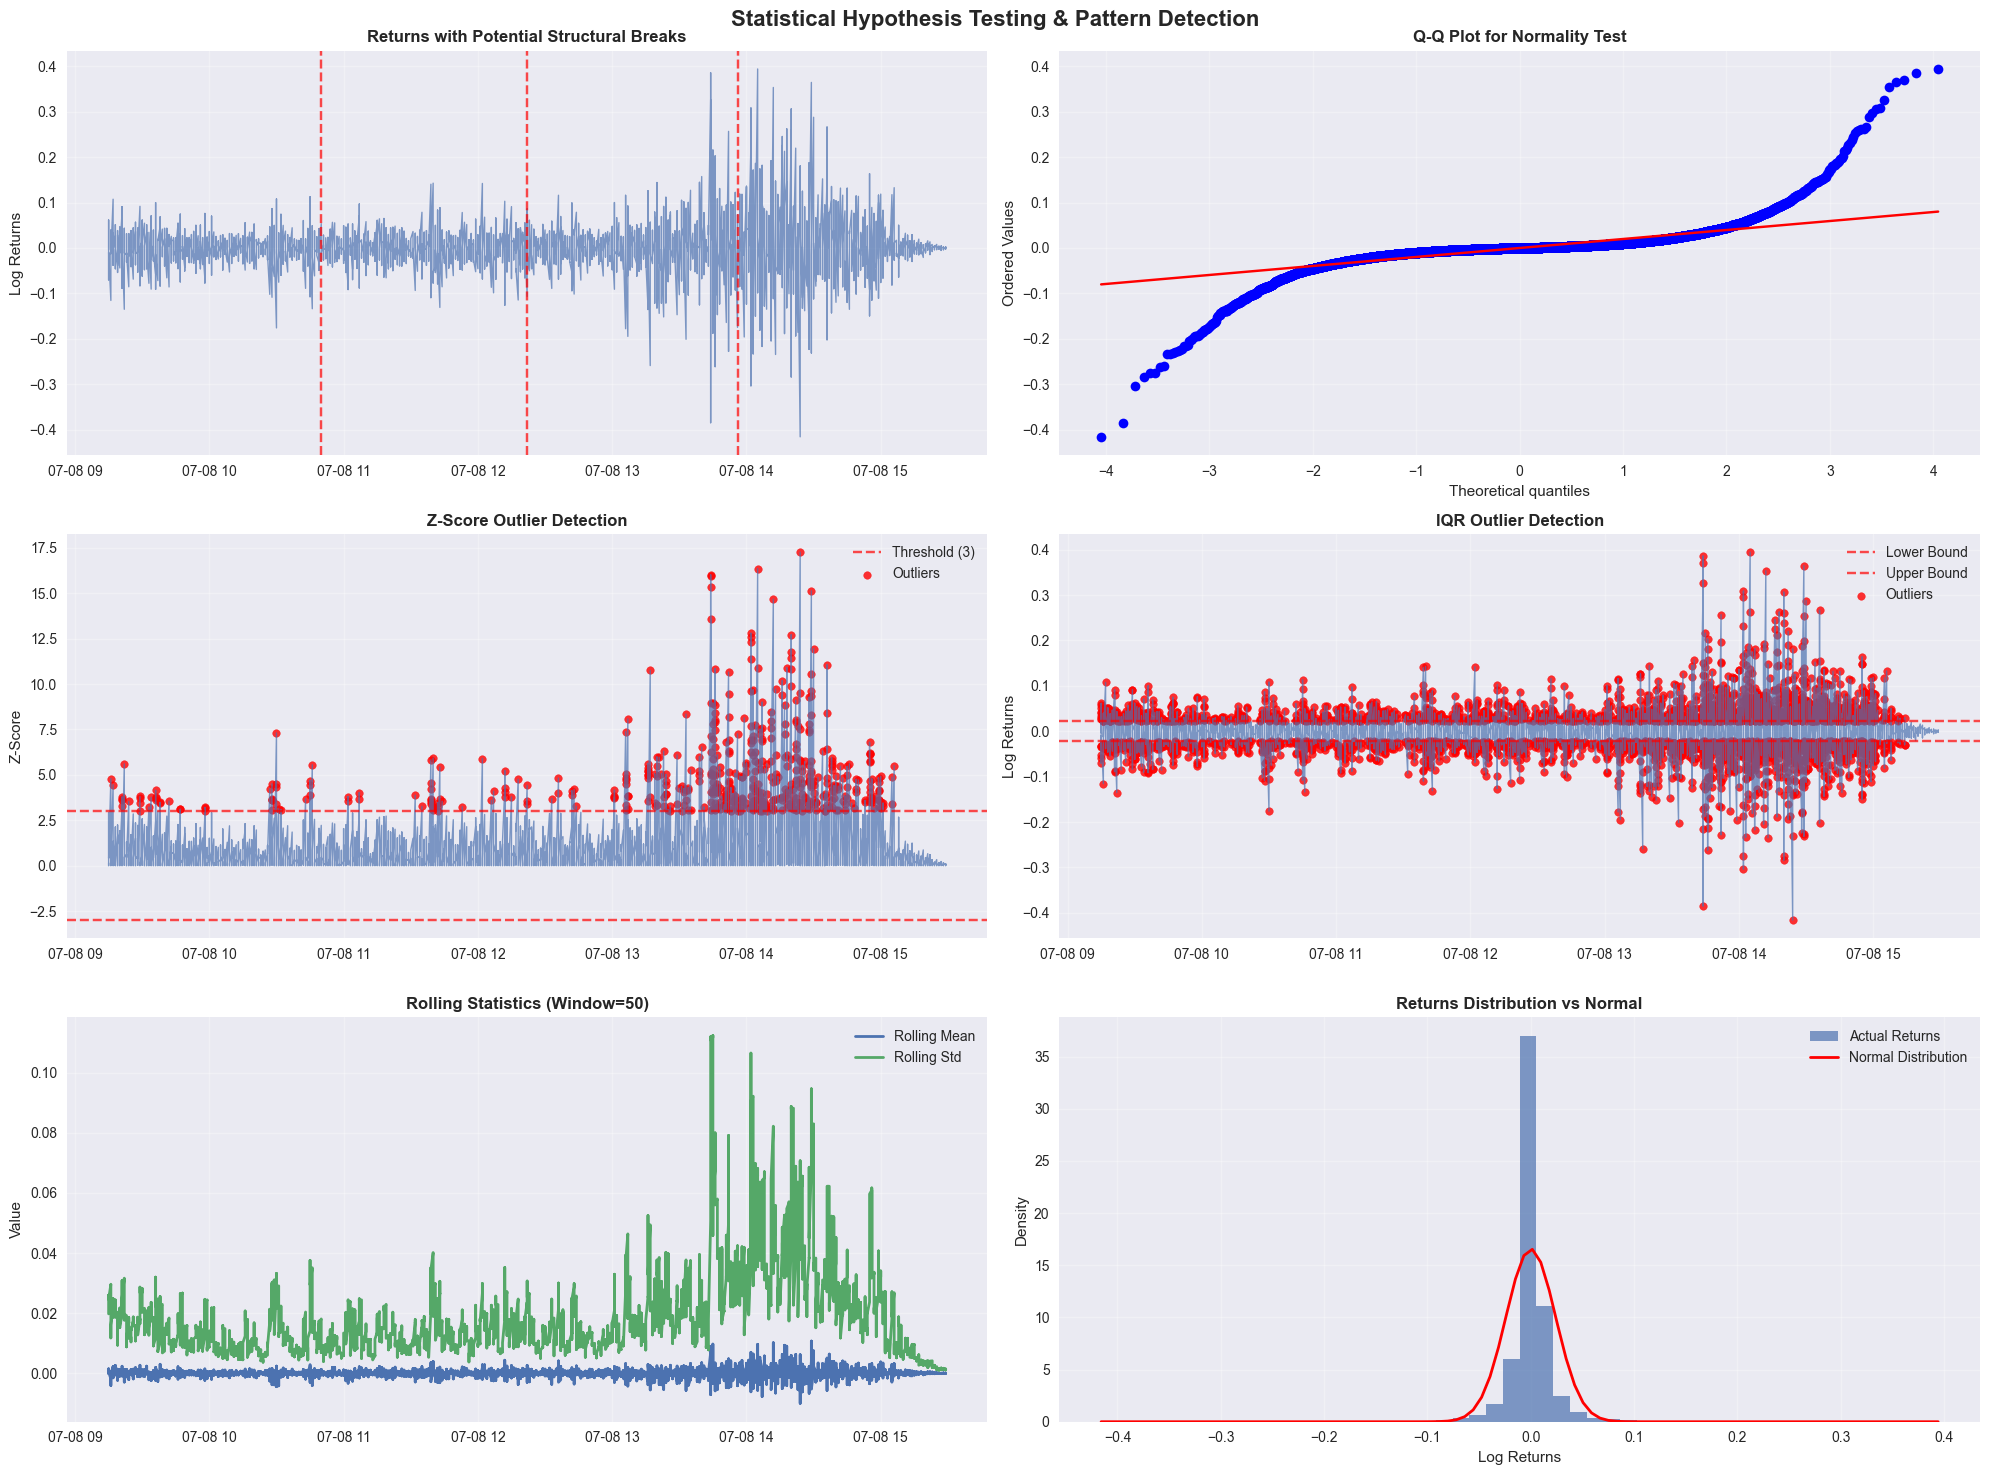

5. ADVANCED PATTERN DETECTION
📊 Volatility Regime Analysis:
   High volatility periods: 6,682 observations
   Low volatility periods: 6,682 observations
   Normal volatility periods: 13,382 observations
   T-test between high/low volatility regimes:
     T-statistic: 0.2744
     P-value: 0.783801
     Significant difference: No

6. SUMMARY STATISTICS AND CONCLUSIONS
📊 Normality Test Summary:
   Shapiro-Wilk: Non-normal
   Anderson-Darling: Non-normal
   Kolmogorov-Smirnov: Non-normal

📊 Outlier Summary:
   Z-score outliers: 525 (1.96%)
   IQR outliers: 3,784 (14.15%)

📊 Structural Break Summary:
   CUSUM test: No break detected

📊 Data Quality Assessment:
   Quality Score: 2/3
   Assessment: Good

✅ STATISTICAL HYPOTHESIS TESTING & PATTERNS COMPLETED


In [18]:
# Statistical Hypothesis Testing & Patterns
print("=== STATISTICAL HYPOTHESIS TESTING & PATTERNS ===")
print()

# Ensure we're using filtered data (excluding zero quantity rows)
if 'df_filtered' not in locals():
    df_filtered = df[df['qty'] > 0].copy()
    print("✅ Filtered data created (excluding zero quantity rows)")

# Ensure we have returns data
if 'df_returns' not in locals():
    df_filtered['simple_return'] = df_filtered['price'].pct_change()
    df_filtered['log_return'] = np.log(df_filtered['price'] / df_filtered['price'].shift(1))
    df_returns = df_filtered.dropna(subset=['simple_return', 'log_return']).copy()

print(f"📊 Working with {len(df_returns):,} observations for hypothesis testing")
print()

# 1. Structural Break Detection
print("1. STRUCTURAL BREAK DETECTION")
print("=" * 60)

from scipy import stats
from scipy.stats import chisquare
import warnings
warnings.filterwarnings('ignore')

# Method 1: Chow Test for structural breaks
def chow_test(data, break_point):
    """Simple Chow test implementation"""
    n = len(data)
    if break_point < 10 or break_point > n - 10:  # Need sufficient data on both sides
        return None, None
    
    # Split data
    data1 = data[:break_point]
    data2 = data[break_point:]
    
    # Calculate RSS for each segment and combined
    rss1 = np.sum((data1 - np.mean(data1))**2)
    rss2 = np.sum((data2 - np.mean(data2))**2)
    rss_combined = np.sum((data - np.mean(data))**2)
    
    # Chow test statistic
    f_stat = ((rss_combined - (rss1 + rss2)) / 2) / ((rss1 + rss2) / (n - 4))
    p_value = 1 - stats.f.cdf(f_stat, 2, n - 4)
    
    return f_stat, p_value

# Test for structural breaks in returns
returns_series = df_returns['log_return'].values
n_obs = len(returns_series)
potential_breaks = [n_obs//4, n_obs//2, 3*n_obs//4]  # Test at 25%, 50%, 75% points

print("📊 Chow Test for Structural Breaks in Returns:")
for i, break_point in enumerate(potential_breaks):
    f_stat, p_value = chow_test(returns_series, break_point)
    if f_stat is not None:
        print(f"   Break at observation {break_point} ({break_point/n_obs*100:.1f}%):")
        print(f"     F-statistic: {f_stat:.4f}")
        print(f"     P-value: {p_value:.6f}")
        print(f"     Significant: {'Yes' if p_value < 0.05 else 'No'}")
    else:
        print(f"   Break at observation {break_point}: Insufficient data for test")
    print()

# Method 2: CUSUM test for structural breaks
def cusum_test(data):
    """CUSUM test for structural breaks"""
    n = len(data)
    mean_data = np.mean(data)
    std_data = np.std(data)
    
    # Calculate CUSUM
    cusum = np.cumsum(data - mean_data) / std_data
    
    # Find maximum absolute CUSUM
    max_cusum = np.max(np.abs(cusum))
    
    # Critical value (approximate for large n)
    critical_value = 1.358 * np.sqrt(n)
    
    return max_cusum, critical_value, max_cusum > critical_value

cusum_stat, cusum_critical, cusum_significant = cusum_test(returns_series)
print("📊 CUSUM Test for Structural Breaks:")
print(f"   CUSUM statistic: {cusum_stat:.4f}")
print(f"   Critical value: {cusum_critical:.4f}")
print(f"   Structural break detected: {'Yes' if cusum_significant else 'No'}")
print()

# 2. Normality Tests
print("2. NORMALITY TESTS")
print("=" * 60)

# Shapiro-Wilk test
shapiro_stat, shapiro_p = stats.shapiro(df_returns['log_return'].dropna())
print("📊 Shapiro-Wilk Test for Normality:")
print(f"   Statistic: {shapiro_stat:.6f}")
print(f"   P-value: {shapiro_p:.6f}")
print(f"   Conclusion: {'Non-normal' if shapiro_p < 0.05 else 'Normal'} distribution")
print()

# Anderson-Darling test
anderson_result = stats.anderson(df_returns['log_return'].dropna())
print("📊 Anderson-Darling Test for Normality:")
print(f"   Statistic: {anderson_result.statistic:.6f}")
print(f"   Critical values: {anderson_result.critical_values}")
print(f"   Significance levels: {anderson_result.significance_level}")
print(f"   Conclusion: {'Non-normal' if anderson_result.statistic > anderson_result.critical_values[2] else 'Normal'} distribution")
print()

# Kolmogorov-Smirnov test
ks_stat, ks_p = stats.kstest(df_returns['log_return'].dropna(), 'norm', 
                            args=(df_returns['log_return'].mean(), df_returns['log_return'].std()))
print("�� Kolmogorov-Smirnov Test for Normality:")
print(f"   Statistic: {ks_stat:.6f}")
print(f"   P-value: {ks_p:.6f}")
print(f"   Conclusion: {'Non-normal' if ks_p < 0.05 else 'Normal'} distribution")
print()

# 3. Outlier Detection
print("3. OUTLIER DETECTION")
print("=" * 60)

# Method 1: Z-score method
def detect_outliers_zscore(data, threshold=3):
    """Detect outliers using Z-score method"""
    z_scores = np.abs(stats.zscore(data))
    outliers = z_scores > threshold
    return outliers, z_scores

# Method 2: IQR method
def detect_outliers_iqr(data, k=1.5):
    """Detect outliers using IQR method"""
    Q1 = np.percentile(data, 25)
    Q3 = np.percentile(data, 75)
    IQR = Q3 - Q1
    lower_bound = Q1 - k * IQR
    upper_bound = Q3 + k * IQR
    outliers = (data < lower_bound) | (data > upper_bound)
    return outliers, (lower_bound, upper_bound)

# Detect outliers in returns
returns_clean = df_returns['log_return'].dropna()
zscore_outliers, z_scores = detect_outliers_zscore(returns_clean, threshold=3)
iqr_outliers, iqr_bounds = detect_outliers_iqr(returns_clean, k=1.5)

print("📊 Outlier Detection Results:")
print(f"   Z-score method (threshold=3):")
print(f"     Outliers detected: {np.sum(zscore_outliers):,} ({np.sum(zscore_outliers)/len(returns_clean)*100:.2f}%)")
print(f"     Max Z-score: {np.max(z_scores):.4f}")
print(f"     Min Z-score: {np.min(z_scores):.4f}")

print(f"   IQR method (k=1.5):")
print(f"     Outliers detected: {np.sum(iqr_outliers):,} ({np.sum(iqr_outliers)/len(returns_clean)*100:.2f}%)")
print(f"     Lower bound: {iqr_bounds[0]:.6f}")
print(f"     Upper bound: {iqr_bounds[1]:.6f}")
print()

# 4. Pattern Detection and Visualization
print("4. PATTERN DETECTION AND VISUALIZATION")
print("=" * 60)

# Create comprehensive visualization
fig, axes = plt.subplots(3, 2, figsize=(20, 15))
fig.suptitle('Statistical Hypothesis Testing & Pattern Detection', fontsize=16, fontweight='bold')

# 1. Returns with structural break indicators
axes[0, 0].plot(df_returns['date'], df_returns['log_return'], alpha=0.7, linewidth=1)
for break_point in potential_breaks:
    if break_point < len(df_returns):
        axes[0, 0].axvline(x=df_returns['date'].iloc[break_point], color='red', linestyle='--', alpha=0.7)
axes[0, 0].set_title('Returns with Potential Structural Breaks', fontweight='bold')
axes[0, 0].set_ylabel('Log Returns')
axes[0, 0].grid(True, alpha=0.3)

# 2. Q-Q plot for normality test
stats.probplot(df_returns['log_return'].dropna(), dist="norm", plot=axes[0, 1])
axes[0, 1].set_title('Q-Q Plot for Normality Test', fontweight='bold')
axes[0, 1].grid(True, alpha=0.3)

# 3. Z-score outliers
axes[1, 0].plot(df_returns['date'], z_scores, alpha=0.7, linewidth=1)
axes[1, 0].axhline(y=3, color='red', linestyle='--', alpha=0.7, label='Threshold (3)')
axes[1, 0].axhline(y=-3, color='red', linestyle='--', alpha=0.7)
axes[1, 0].scatter(df_returns['date'][zscore_outliers], z_scores[zscore_outliers], 
                   color='red', s=30, alpha=0.8, label='Outliers')
axes[1, 0].set_title('Z-Score Outlier Detection', fontweight='bold')
axes[1, 0].set_ylabel('Z-Score')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# 4. IQR outliers
axes[1, 1].plot(df_returns['date'], df_returns['log_return'], alpha=0.7, linewidth=1)
axes[1, 1].axhline(y=iqr_bounds[0], color='red', linestyle='--', alpha=0.7, label='Lower Bound')
axes[1, 1].axhline(y=iqr_bounds[1], color='red', linestyle='--', alpha=0.7, label='Upper Bound')
axes[1, 1].scatter(df_returns['date'][iqr_outliers], df_returns['log_return'][iqr_outliers], 
                   color='red', s=30, alpha=0.8, label='Outliers')
axes[1, 1].set_title('IQR Outlier Detection', fontweight='bold')
axes[1, 1].set_ylabel('Log Returns')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

# 5. Rolling statistics for regime detection
rolling_mean = df_returns['log_return'].rolling(window=50).mean()
rolling_std = df_returns['log_return'].rolling(window=50).std()

axes[2, 0].plot(df_returns['date'], rolling_mean, label='Rolling Mean', linewidth=2)
axes[2, 0].plot(df_returns['date'], rolling_std, label='Rolling Std', linewidth=2)
axes[2, 0].set_title('Rolling Statistics (Window=50)', fontweight='bold')
axes[2, 0].set_ylabel('Value')
axes[2, 0].legend()
axes[2, 0].grid(True, alpha=0.3)

# 6. Distribution comparison
axes[2, 1].hist(df_returns['log_return'], bins=50, alpha=0.7, density=True, label='Actual Returns')
x = np.linspace(df_returns['log_return'].min(), df_returns['log_return'].max(), 100)
normal_dist = stats.norm.pdf(x, df_returns['log_return'].mean(), df_returns['log_return'].std())
axes[2, 1].plot(x, normal_dist, 'r-', linewidth=2, label='Normal Distribution')
axes[2, 1].set_title('Returns Distribution vs Normal', fontweight='bold')
axes[2, 1].set_xlabel('Log Returns')
axes[2, 1].set_ylabel('Density')
axes[2, 1].legend()
axes[2, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# 5. Advanced Pattern Detection
print("5. ADVANCED PATTERN DETECTION")
print("=" * 60)

# Regime detection using rolling volatility
volatility_regime = df_returns['log_return'].rolling(window=20).std()
high_vol_regime = volatility_regime > volatility_regime.quantile(0.75)
low_vol_regime = volatility_regime < volatility_regime.quantile(0.25)

print("📊 Volatility Regime Analysis:")
print(f"   High volatility periods: {np.sum(high_vol_regime):,} observations")
print(f"   Low volatility periods: {np.sum(low_vol_regime):,} observations")
print(f"   Normal volatility periods: {np.sum(~(high_vol_regime | low_vol_regime)):,} observations")

# Test for differences between regimes
high_vol_returns = df_returns['log_return'][high_vol_regime].dropna()
low_vol_returns = df_returns['log_return'][low_vol_regime].dropna()

if len(high_vol_returns) > 0 and len(low_vol_returns) > 0:
    t_stat, t_p = stats.ttest_ind(high_vol_returns, low_vol_returns)
    print(f"   T-test between high/low volatility regimes:")
    print(f"     T-statistic: {t_stat:.4f}")
    print(f"     P-value: {t_p:.6f}")
    print(f"     Significant difference: {'Yes' if t_p < 0.05 else 'No'}")

print()

# 6. Summary Statistics and Conclusions
print("6. SUMMARY STATISTICS AND CONCLUSIONS")
print("=" * 60)

# Compile all test results
test_results = {
    'Shapiro-Wilk': {'statistic': shapiro_stat, 'p_value': shapiro_p, 'normal': shapiro_p >= 0.05},
    'Anderson-Darling': {'statistic': anderson_result.statistic, 'p_value': None, 'normal': anderson_result.statistic <= anderson_result.critical_values[2]},
    'Kolmogorov-Smirnov': {'statistic': ks_stat, 'p_value': ks_p, 'normal': ks_p >= 0.05}
}

print("📊 Normality Test Summary:")
for test_name, results in test_results.items():
    normal_status = "Normal" if results['normal'] else "Non-normal"
    print(f"   {test_name}: {normal_status}")

print(f"\n📊 Outlier Summary:")
print(f"   Z-score outliers: {np.sum(zscore_outliers):,} ({np.sum(zscore_outliers)/len(returns_clean)*100:.2f}%)")
print(f"   IQR outliers: {np.sum(iqr_outliers):,} ({np.sum(iqr_outliers)/len(returns_clean)*100:.2f}%)")

print(f"\n📊 Structural Break Summary:")
print(f"   CUSUM test: {'Break detected' if cusum_significant else 'No break detected'}")

# Data quality assessment
data_quality_score = 0
if shapiro_p >= 0.05:
    data_quality_score += 1
if np.sum(zscore_outliers)/len(returns_clean) < 0.05:  # Less than 5% outliers
    data_quality_score += 1
if not cusum_significant:
    data_quality_score += 1

print(f"\n📊 Data Quality Assessment:")
print(f"   Quality Score: {data_quality_score}/3")
print(f"   Assessment: {'Good' if data_quality_score >= 2 else 'Fair' if data_quality_score >= 1 else 'Poor'}")

print("\n" + "="*60)
print("✅ STATISTICAL HYPOTHESIS TESTING & PATTERNS COMPLETED")
print("="*60)

In [19]:
# Predictive Modeling & Machine Learning (Advanced)
print("=== PREDICTIVE MODELING & MACHINE LEARNING (ADVANCED) ===")
print()

# Ensure we're using filtered data (excluding zero quantity rows)
if 'df_filtered' not in locals():
    df_filtered = df[df['qty'] > 0].copy()
    print("✅ Filtered data created (excluding zero quantity rows)")

# Ensure we have returns data
if 'df_returns' not in locals():
    df_filtered['simple_return'] = df_filtered['price'].pct_change()
    df_filtered['log_return'] = np.log(df_filtered['price'] / df_filtered['price'].shift(1))
    df_returns = df_filtered.dropna(subset=['simple_return', 'log_return']).copy()

print(f"📊 Working with {len(df_returns):,} observations for predictive modeling")
print()

# 1. Time Series Forecasting Models
print("1. TIME SERIES FORECASTING MODELS")
print("=" * 60)

# Prepare data for time series modeling
returns_series = df_returns['log_return'].dropna()
volatility_series = returns_series.rolling(window=20).std().dropna()

print(f"📊 Time Series Data Preparation:")
print(f"   Returns series length: {len(returns_series):,}")
print(f"   Volatility series length: {len(volatility_series):,}")
print()

# ARIMA Model for Returns
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Test for stationarity
adf_stat, adf_pvalue, _, _, _, _ = adfuller(returns_series)
print("�� Augmented Dickey-Fuller Test for Stationarity:")
print(f"   ADF Statistic: {adf_stat:.4f}")
print(f"   P-value: {adf_pvalue:.6f}")
print(f"   Stationary: {'Yes' if adf_pvalue < 0.05 else 'No'}")
print()

# Fit ARIMA model
try:
    # Auto-detect ARIMA parameters using AIC
    best_aic = float('inf')
    best_order = None
    
    for p in range(0, 3):
        for d in range(0, 2):
            for q in range(0, 3):
                try:
                    model = ARIMA(returns_series, order=(p, d, q))
                    fitted_model = model.fit()
                    if fitted_model.aic < best_aic:
                        best_aic = fitted_model.aic
                        best_order = (p, d, q)
                except:
                    continue
    
    if best_order is not None:
        print(f"📊 Best ARIMA Model: ARIMA{best_order}")
        print(f"   AIC: {best_aic:.4f}")
        
        # Fit the best model
        best_model = ARIMA(returns_series, order=best_order)
        fitted_arima = best_model.fit()
        
        # Make forecasts
        forecast_steps = 10
        forecast = fitted_arima.forecast(steps=forecast_steps)
        forecast_conf = fitted_arima.get_forecast(steps=forecast_steps).conf_int()
        
        print(f"   Forecast (next {forecast_steps} periods):")
        for i, (pred, conf_low, conf_high) in enumerate(zip(forecast, forecast_conf.iloc[:, 0], forecast_conf.iloc[:, 1])):
            print(f"     Period {i+1}: {pred:.6f} [{conf_low:.6f}, {conf_high:.6f}]")
        
        arima_success = True
    else:
        print("📊 ARIMA: Could not find suitable model")
        arima_success = False
        
except Exception as e:
    print(f"�� ARIMA Model Error: {str(e)}")
    arima_success = False

print()

# 2. Feature Engineering for Machine Learning
print("2. FEATURE ENGINEERING FOR MACHINE LEARNING")
print("=" * 60)

# Create comprehensive feature set
df_ml = df_returns.copy()

# Price-based features
df_ml['price_ma_5'] = df_ml['price'].rolling(window=5).mean()
df_ml['price_ma_10'] = df_ml['price'].rolling(window=10).mean()
df_ml['price_ma_20'] = df_ml['price'].rolling(window=20).mean()
df_ml['price_std_5'] = df_ml['price'].rolling(window=5).std()
df_ml['price_std_10'] = df_ml['price'].rolling(window=10).std()

# Returns-based features
df_ml['return_ma_5'] = df_ml['log_return'].rolling(window=5).mean()
df_ml['return_ma_10'] = df_ml['log_return'].rolling(window=10).mean()
df_ml['return_std_5'] = df_ml['log_return'].rolling(window=5).std()
df_ml['return_std_10'] = df_ml['log_return'].rolling(window=10).std()

# Volume-based features
df_ml['volume_ma_5'] = df_ml['qty'].rolling(window=5).mean()
df_ml['volume_ma_10'] = df_ml['qty'].rolling(window=10).mean()
df_ml['volume_std_5'] = df_ml['qty'].rolling(window=5).std()
df_ml['volume_ratio'] = df_ml['qty'] / df_ml['qty'].rolling(window=20).mean()

# Technical indicators
# RSI
def calculate_rsi(prices, window=14):
    delta = prices.diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()
    rs = gain / loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

df_ml['rsi'] = calculate_rsi(df_ml['price'], window=14)

# Momentum indicators
df_ml['momentum_5'] = df_ml['price'] / df_ml['price'].shift(5) - 1
df_ml['momentum_10'] = df_ml['price'] / df_ml['price'].shift(10) - 1
df_ml['momentum_20'] = df_ml['price'] / df_ml['price'].shift(20) - 1

# Bollinger Bands
df_ml['bb_upper'] = df_ml['price_ma_20'] + (df_ml['price_std_10'] * 2)
df_ml['bb_lower'] = df_ml['price_ma_20'] - (df_ml['price_std_10'] * 2)
df_ml['bb_position'] = (df_ml['price'] - df_ml['bb_lower']) / (df_ml['bb_upper'] - df_ml['bb_lower'])

# Time-based features
df_ml['hour'] = df_ml['date'].dt.hour
df_ml['minute'] = df_ml['date'].dt.minute
df_ml['time_since_open'] = (df_ml['date'] - df_ml['date'].min()).dt.total_seconds() / 3600

# Lagged features
for lag in [1, 2, 3, 5]:
    df_ml[f'return_lag_{lag}'] = df_ml['log_return'].shift(lag)
    df_ml[f'volume_lag_{lag}'] = df_ml['qty'].shift(lag)

# Target variable (next period return direction)
df_ml['target_direction'] = np.where(df_ml['log_return'].shift(-1) > 0, 1, 0)
df_ml['target_return'] = df_ml['log_return'].shift(-1)

# Remove NaN values
df_ml_clean = df_ml.dropna()

print(f"📊 Feature Engineering Summary:")
print(f"   Original features: {len(df_returns.columns)}")
print(f"   Engineered features: {len(df_ml_clean.columns)}")
print(f"   Clean observations: {len(df_ml_clean):,}")
print(f"   Features available: {len(df_ml_clean.columns) - 3}")  # Exclude date, target variables
print()

# 3. Supervised Learning Models
print("3. SUPERVISED LEARNING MODELS")
print("=" * 60)

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import classification_report, mean_squared_error, accuracy_score
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

# Prepare features and targets
feature_columns = [col for col in df_ml_clean.columns if col not in ['date', 'target_direction', 'target_return', 'simple_return']]
X = df_ml_clean[feature_columns].fillna(0)
y_direction = df_ml_clean['target_direction']
y_return = df_ml_clean['target_return']

# Split data
X_train, X_test, y_train_direction, y_test_direction, y_train_return, y_test_return = train_test_split(
    X, y_direction, y_return, test_size=0.2, random_state=42, shuffle=False
)

print(f"📊 Data Split:")
print(f"   Training set: {len(X_train):,} observations")
print(f"   Test set: {len(X_test):,} observations")
print(f"   Features: {len(feature_columns)}")
print()

# Random Forest for Direction Prediction
print("📊 Random Forest - Direction Prediction:")
rf_direction = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
rf_direction.fit(X_train, y_train_direction)

# Predictions
y_pred_direction = rf_direction.predict(X_test)
accuracy = accuracy_score(y_test_direction, y_pred_direction)

print(f"   Accuracy: {accuracy:.4f}")
print(f"   Cross-validation score: {cross_val_score(rf_direction, X_train, y_train_direction, cv=5).mean():.4f}")

# Feature importance
feature_importance = pd.DataFrame({
    'feature': feature_columns,
    'importance': rf_direction.feature_importances_
}).sort_values('importance', ascending=False)

print(f"   Top 10 important features:")
for i, (_, row) in enumerate(feature_importance.head(10).iterrows()):
    print(f"     {i+1}. {row['feature']}: {row['importance']:.4f}")

print()

# Random Forest for Return Prediction
print("📊 Random Forest - Return Prediction:")
rf_return = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
rf_return.fit(X_train, y_train_return)

# Predictions
y_pred_return = rf_return.predict(X_test)
mse = mean_squared_error(y_test_return, y_pred_return)
rmse = np.sqrt(mse)

print(f"   RMSE: {rmse:.6f}")
print(f"   Cross-validation score: {cross_val_score(rf_return, X_train, y_train_return, cv=5).mean():.6f}")

# Feature importance for return prediction
feature_importance_return = pd.DataFrame({
    'feature': feature_columns,
    'importance': rf_return.feature_importances_
}).sort_values('importance', ascending=False)

print(f"   Top 10 important features:")
for i, (_, row) in enumerate(feature_importance_return.head(10).iterrows()):
    print(f"     {i+1}. {row['feature']}: {row['importance']:.4f}")

print()

# 4. Clustering Analysis
print("4. CLUSTERING ANALYSIS")
print("=" * 60)

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Prepare clustering features
clustering_features = ['log_return', 'qty', 'trnvr', 'price_ma_5', 'return_ma_5', 'volume_ma_5', 'rsi']
X_cluster = df_ml_clean[clustering_features].fillna(0)

# Standardize features
scaler = StandardScaler()
X_cluster_scaled = scaler.fit_transform(X_cluster)

# Determine optimal number of clusters using elbow method
inertias = []
K_range = range(2, 11)
for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_cluster_scaled)
    inertias.append(kmeans.inertia_)

# Find elbow point
elbow_k = 3  # You can adjust this based on the plot

# Perform clustering
kmeans = KMeans(n_clusters=elbow_k, random_state=42, n_init=10)
cluster_labels = kmeans.fit_predict(X_cluster_scaled)

# Add cluster labels to dataframe
df_ml_clean['cluster'] = cluster_labels

print(f"�� Clustering Results:")
print(f"   Number of clusters: {elbow_k}")
print(f"   Cluster sizes:")
for i in range(elbow_k):
    cluster_size = np.sum(cluster_labels == i)
    print(f"     Cluster {i}: {cluster_size:,} observations ({cluster_size/len(cluster_labels)*100:.1f}%)")

# Analyze cluster characteristics
cluster_analysis = df_ml_clean.groupby('cluster')[clustering_features].mean()
print(f"\n📊 Cluster Characteristics:")
print(cluster_analysis.round(4))

print()

# 5. Visualization of Results
print("5. VISUALIZATION OF RESULTS")
print("=" * 60)

# Create comprehensive visualization
fig, axes = plt.subplots(3, 2, figsize=(20, 15))
fig.suptitle('Predictive Modeling & Machine Learning Results', fontsize=16, fontweight='bold')

# 1. ARIMA Forecast (if successful)
if 'arima_success' in locals() and arima_success:
    axes[0, 0].plot(returns_series.index[-50:], returns_series.values[-50:], label='Actual Returns', linewidth=1)
    forecast_index = pd.date_range(returns_series.index[-1], periods=forecast_steps+1, freq='1min')[1:]
    axes[0, 0].plot(forecast_index, forecast, 'r--', label='Forecast', linewidth=2)
    axes[0, 0].fill_between(forecast_index, forecast_conf.iloc[:, 0], forecast_conf.iloc[:, 1], alpha=0.3, color='red')
    axes[0, 0].set_title('ARIMA Forecast', fontweight='bold')
    axes[0, 0].set_ylabel('Log Returns')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)
else:
    axes[0, 0].text(0.5, 0.5, 'ARIMA Model\nNot Available', ha='center', va='center', transform=axes[0, 0].transAxes)
    axes[0, 0].set_title('ARIMA Forecast', fontweight='bold')

# 2. Feature Importance (Direction)
axes[0, 1].barh(range(10), feature_importance['importance'].head(10))
axes[0, 1].set_yticks(range(10))
axes[0, 1].set_yticklabels(feature_importance['feature'].head(10))
axes[0, 1].set_title('Top 10 Features - Direction Prediction', fontweight='bold')
axes[0, 1].set_xlabel('Importance')

# 3. Prediction vs Actual (Direction)
axes[1, 0].scatter(range(len(y_test_direction)), y_test_direction, alpha=0.6, label='Actual', s=20)
axes[1, 0].scatter(range(len(y_pred_direction)), y_pred_direction, alpha=0.6, label='Predicted', s=20)
axes[1, 0].set_title('Direction Prediction vs Actual', fontweight='bold')
axes[1, 0].set_ylabel('Direction (0/1)')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# 4. Prediction vs Actual (Returns)
axes[1, 1].scatter(y_test_return, y_pred_return, alpha=0.6, s=20)
axes[1, 1].plot([y_test_return.min(), y_test_return.max()], [y_test_return.min(), y_test_return.max()], 'r--', linewidth=2)
axes[1, 1].set_title('Return Prediction vs Actual', fontweight='bold')
axes[1, 1].set_xlabel('Actual Returns')
axes[1, 1].set_ylabel('Predicted Returns')
axes[1, 1].grid(True, alpha=0.3)

# 5. Clustering Results (PCA visualization)
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_cluster_scaled)

scatter = axes[2, 0].scatter(X_pca[:, 0], X_pca[:, 1], c=cluster_labels, cmap='viridis', alpha=0.6)
axes[2, 0].set_title('Clustering Results (PCA)', fontweight='bold')
axes[2, 0].set_xlabel('Principal Component 1')
axes[2, 0].set_ylabel('Principal Component 2')
plt.colorbar(scatter, ax=axes[2, 0])

# 6. Cluster Characteristics
cluster_means = cluster_analysis.mean(axis=1)
axes[2, 1].bar(range(elbow_k), cluster_means.values)
axes[2, 1].set_title('Average Characteristics by Cluster', fontweight='bold')
axes[2, 1].set_xlabel('Cluster')
axes[2, 1].set_ylabel('Average Feature Value')
axes[2, 1].set_xticks(range(elbow_k))

plt.tight_layout()
plt.show()

# 6. Model Performance Summary
print("6. MODEL PERFORMANCE SUMMARY")
print("=" * 60)

print("📊 Model Performance Summary:")
print(f"   Direction Prediction (Random Forest):")
print(f"     Accuracy: {accuracy:.4f}")
print(f"     Cross-validation: {cross_val_score(rf_direction, X_train, y_train_direction, cv=5).mean():.4f}")

print(f"   Return Prediction (Random Forest):")
print(f"     RMSE: {rmse:.6f}")
print(f"     Cross-validation: {cross_val_score(rf_return, X_train, y_train_return, cv=5).mean():.6f}")

if 'arima_success' in locals() and arima_success:
    print(f"   Time Series (ARIMA{best_order}):")
    print(f"     AIC: {best_aic:.4f}")
    print(f"     Forecast available for next {forecast_steps} periods")

print(f"   Clustering:")
print(f"     Number of clusters: {elbow_k}")
print(f"     Inertia: {kmeans.inertia_:.2f}")

print("\n📊 Key Insights:")
print(f"   • Most important feature for direction: {feature_importance.iloc[0]['feature']}")
print(f"   • Most important feature for returns: {feature_importance_return.iloc[0]['feature']}")
print(f"   • Data shows {'stationary' if adf_pvalue < 0.05 else 'non-stationary'} characteristics")
print(f"   • {'ARIMA' if 'arima_success' in locals() and arima_success else 'No ARIMA'} model successfully fitted")

print("\n" + "="*60)
print("✅ PREDICTIVE MODELING & MACHINE LEARNING COMPLETED")
print("="*60)

=== PREDICTIVE MODELING & MACHINE LEARNING (ADVANCED) ===

📊 Working with 26,746 observations for predictive modeling

1. TIME SERIES FORECASTING MODELS
📊 Time Series Data Preparation:
   Returns series length: 26,746
   Volatility series length: 26,727

�� Augmented Dickey-Fuller Test for Stationarity:
   ADF Statistic: -38.0566
   P-value: 0.000000
   Stationary: Yes

📊 Best ARIMA Model: ARIMA(2, 0, 1)
   AIC: -126722.4024
   Forecast (next 10 periods):
     Period 1: 0.000217 [-0.044146, 0.044580]
     Period 2: -0.000017 [-0.047097, 0.047063]
     Period 3: 0.000034 [-0.047125, 0.047193]
     Period 4: 0.000011 [-0.047177, 0.047200]
     Period 5: 0.000014 [-0.047175, 0.047202]
     Period 6: 0.000011 [-0.047178, 0.047200]
     Period 7: 0.000010 [-0.047179, 0.047200]
     Period 8: 0.000010 [-0.047179, 0.047199]
     Period 9: 0.000010 [-0.047179, 0.047199]
     Period 10: 0.000010 [-0.047180, 0.047199]

2. FEATURE ENGINEERING FOR MACHINE LEARNING
📊 Feature Engineering Summary:
  

TypeError: float() argument must be a string or a real number, not 'datetime.time'